In [8]:
import re
from enum import Enum
from typing import List, Tuple, Dict, Set, Optional, Union, Any, Callable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
def replace_multiple_spaces_by_one(s):
    return re.sub(r" +", " ", s)

In [10]:
class Unit(Enum):
    ns = 1000000000
    us = 1000000
    ms = 1000
    s = 1
    nop = 0

    def __str__(self):
        return self.name

def get_unit(s):
    unit = s.replace("/op", "")
    if unit == "ns":
        return Unit.ns
    elif unit == "us":
        return Unit.us
    elif unit == "ms":
        return Unit.ms
    elif unit == "s":
        return Unit.s
    else:
        raise Exception("Unknown unit")
    
def convert(n:float, current_unit:Unit, new_unit:Unit) -> float:
    return n * current_unit.value / new_unit.value

def verify_unit_or_convert(data: Tuple[Unit, List[Tuple[int, float, float]]], other_data: Tuple[Unit, List[Tuple[int, float, float]]] = ()) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    unit = data[0] if other_data == () else other_data[0]
    if other_data == ():
        # Convert to the best unit for viewing the data
        min_value = min([x[1] for x in data[1]])
        if min_value / float(Unit.s.value) > 1:
            unit = Unit.s
        elif min_value / float(Unit.ms.value) > 1:  
            unit = Unit.ms
        elif min_value / float(Unit.us.value) > 1:
            unit = Unit.us
        else:
            unit = Unit.ns
    u = data[0]
    res = [(x, convert(avg, u, unit), convert(err, u, unit)) for x, avg, err in data[1]]
    res.sort()
    return (unit, res)

In [11]:
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

def plot_data_with_error(plot_name: str,
                         data: Dict[str, Tuple[str, List[Tuple[int, float, float]]]],
                          x_line_at: int = 0, 
                          show_avg: bool = False, 
                          output_folder = ""):
    final_unit = None
    data_without_units: Dict[str, List[Tuple[int, float, float]]]= {}
    for name, (unit, dat) in data.items():
        data_without_units[name] = dat
        if final_unit is not None:
            assert final_unit == unit
        else:
            final_unit = unit
    
    assert len(data.keys()) <= 8


    fig, ax = plt.subplots()

    # Choose colorblind-friendly colors
    colours = ['tab:blue', 'tab:cyan', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    colorBlack = 'black'

    # the error bar is shown in another color, and it the 99% CI
    # The y-axis always starts at 0
    for i, (name, dat) in enumerate(data_without_units.items()):
        ax.errorbar([x for x, _, _ in dat], [y for _, y, _ in dat], yerr=[y for _, _, y in dat], label=name, ecolor=colorBlack, elinewidth=0.8, capsize=2, capthick=0.8, color=colours[i % len(colours)])

    avgs = {}
    for name, dat in data_without_units.items():
        avgs[name] = sum([y for _, y, _ in dat]) / len(dat) if len(dat) > 0 else 0

    max_y_value = max([y for l in data_without_units.values() for _, y, _ in l])

    max_y_value = max_y_value + 0.15 * max_y_value
    ax.set_xlabel("N")
    ax.set_ylabel(f"Time ({final_unit})")

    # Add a vertical line at x = x_line_at if not 0
    if x_line_at != 0:
        ax.axvline(x=x_line_at, color=colorBlack, linestyle='--')

    if show_avg:
        for name, avg in avgs.items():
            ax.axhline(y=avg, color=colours[list(avgs.keys()).index(name)], linestyle='--')

    ax.legend()
    ax.set_title(plot_name)
    
    if output_folder != "":
        # fig.savefig(f"{output_folder}/{plot_name}.png", format='png', dpi=1200)
        file_name = plot_name.replace(" - ", "_").replace(" ", "_").replace("^", "to").replace("&", "and").replace(",", "").replace("(", "").replace(")", "").replace(":", "").replace("/", "_")
        fig.savefig(f"{output_folder}/{file_name}.eps", format='eps')

    plt.show()


In [12]:
def extract_data(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg), float(err)) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy()])

def extract_data_normalised_per_op(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg)/float(param), float(err)/float(param) ) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy() if int(param) != 0] )

def normalise_data_wrt_value(data: Tuple[Unit, List[Tuple[int, float, float]]], value: float)-> Tuple[Unit, List[Tuple[int, float, float]]]:
    return (Unit.nop, [(x, avg/value, err/value) for x, avg, err in data[1]])


In [13]:
def create_plots(benchmark_classes: List[str], 
                 benchmark_names: Dict[str, List[str]], 
                 maps_to_show: List[str], 
                 baseline: str, 
                 df: pd.DataFrame, 
                 variable_names: Dict[str, str] = {}, 
                 show_avg_for: str = "never", 
                 pretty_benchmark_names: Dict[str, str] = {}, 
                 output_folder = ""):
    for c in benchmark_classes:
        benchmark_func_names = benchmark_names[c]
        for n in benchmark_func_names:
            benchm_name = f"{c}.{n}"
            
            bench_name_pretty = f"{n}"
            print(benchm_name)
            if benchm_name in pretty_benchmark_names:
                bench_name_pretty = pretty_benchmark_names[benchm_name]
            
            variable_name = variable_names[c]

            data = {}
            for m in maps_to_show:
                if len(data) == 0:
                    data[m] = verify_unit_or_convert(extract_data(df, benchm_name, m, variable_name))
                else:
                    data[m] = verify_unit_or_convert(extract_data(df, benchm_name, m, variable_name), data[maps_to_show[0]])

            x_line_at = 0
            if "MutableLongMapBenchmarkBig" in c:
                x_line_at = 2**22
            elif "MutableLongMapBenchmark" in c:
                x_line_at = 2**15

            plot_data_with_error(bench_name_pretty, data, x_line_at, show_avg_for == "always", output_folder = output_folder)

            # Create the same plot but normalised with respect to the first value of the baseline
            val_normalised_against = data[baseline][1][0][1]

            normalised_data = {}
            for m, (unit, dat) in data.items():
                normalised_data[m] = normalise_data_wrt_value(data[m], val_normalised_against)

            plot_data_with_error(bench_name_pretty + " (norm.)", normalised_data, x_line_at, show_avg_for == "always", output_folder = output_folder)

            if "lookupn" in n.lower():
            # plot the data normalised per operation
                data_normalised_per_op = {}
                for m in maps_to_show:
                    if len(data_normalised_per_op) == 0:
                        data_normalised_per_op[m] = verify_unit_or_convert(extract_data_normalised_per_op(df, benchm_name, m, variable_name))
                    else:
                        data_normalised_per_op[m] = verify_unit_or_convert(extract_data_normalised_per_op(df, benchm_name, m, variable_name), data_normalised_per_op[maps_to_show[0]])
                
                plot_data_with_error(bench_name_pretty + " (per op)", data_normalised_per_op, x_line_at, show_avg_for == "normalised", output_folder = output_folder)
                
                # Create the same plot but normalised with respect to the avg value of the baseline
                val_normalised_against = sum([y for _, y, _ in data_normalised_per_op[baseline][1]]) / len(data_normalised_per_op[baseline][1])

                normalised_data_per_op_wrt_baseline = {}
                for m, (unit, dat) in data_normalised_per_op.items():

                    normalised_data_per_op_wrt_baseline[m] = normalise_data_wrt_value(data_normalised_per_op[m], val_normalised_against)
                
                plot_data_with_error(bench_name_pretty + " (per op, norm.)", normalised_data_per_op_wrt_baseline, x_line_at, show_avg_for == "normalised", output_folder = output_folder)


# Clean version

This version does not support data from ListMap Benchmark, for this use the benchmark_analysis_dev.ipynb notebook.

## Below here data from benchmark 24.11 on laraquad3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


MutableLongMapBenchmark.createUpdateLookup_2to17Buffer


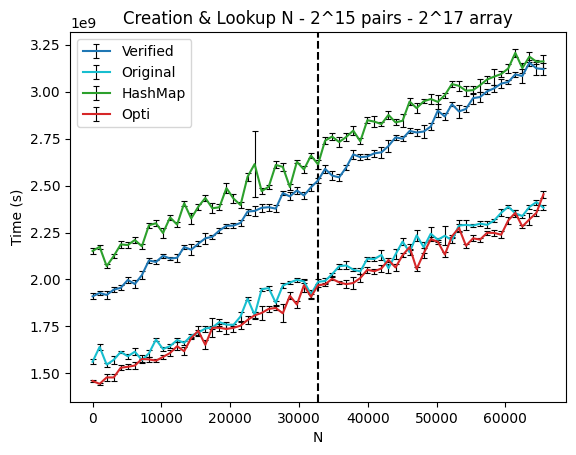

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


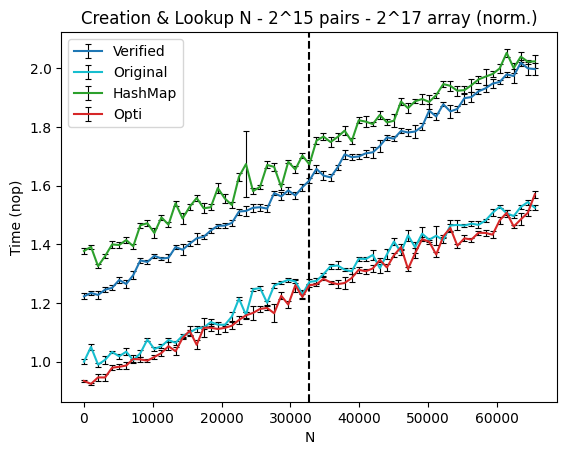

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


MutableLongMapBenchmark.createUpdateLookup_16Buffer


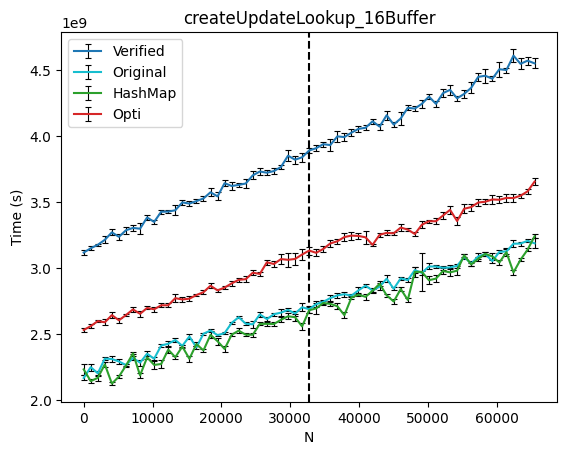

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


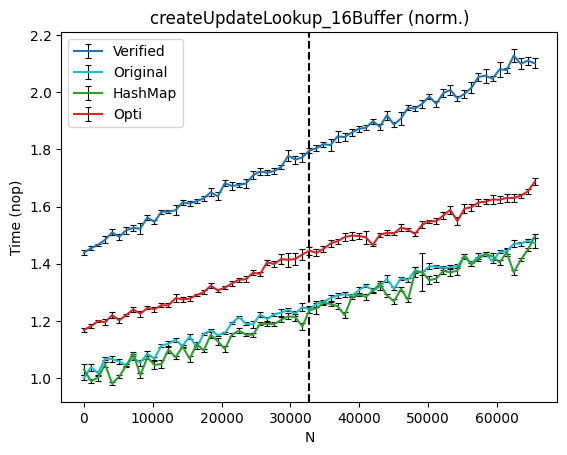

MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


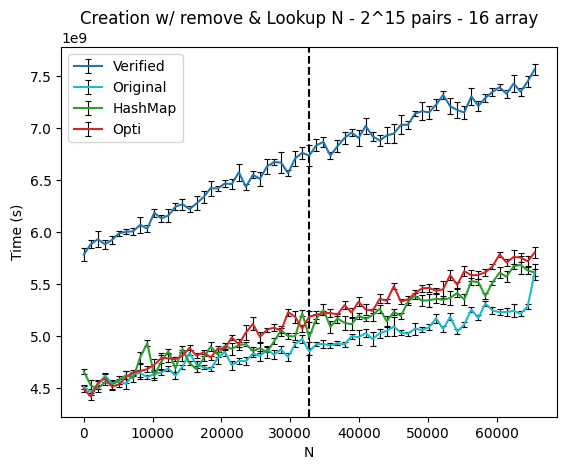

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


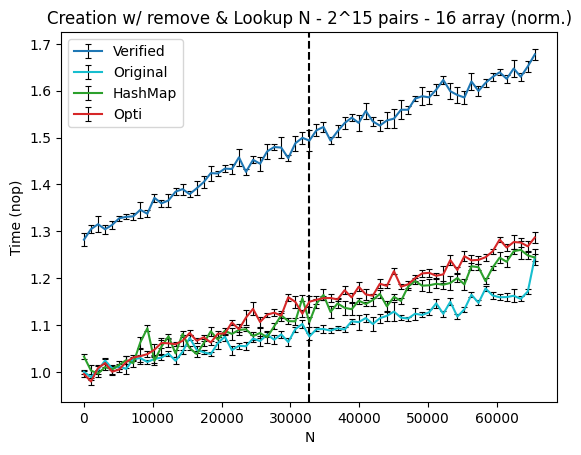

MutableLongMapBenchmark.lookupN


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


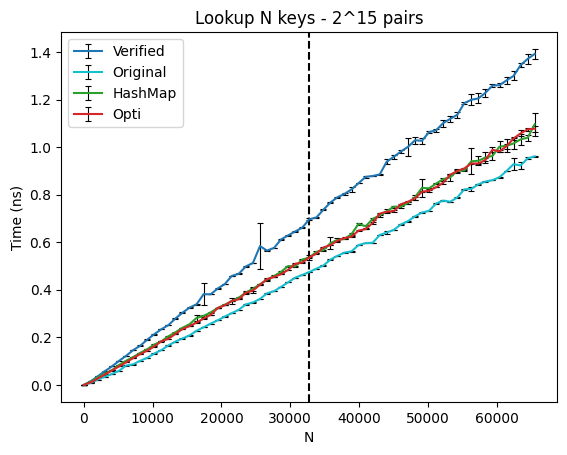

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


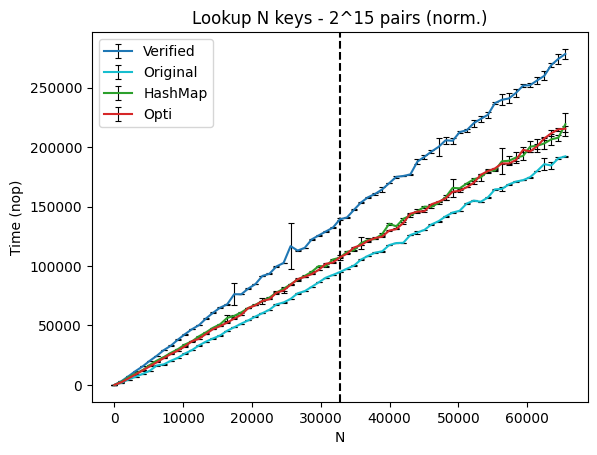

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


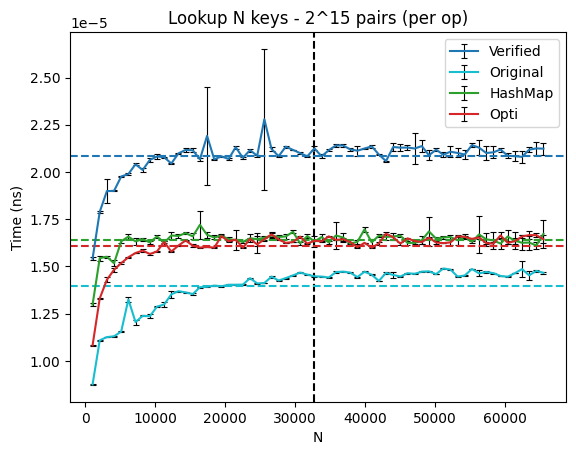

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


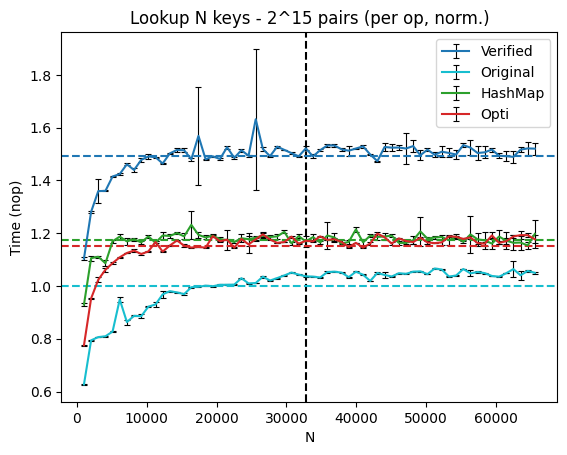

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer


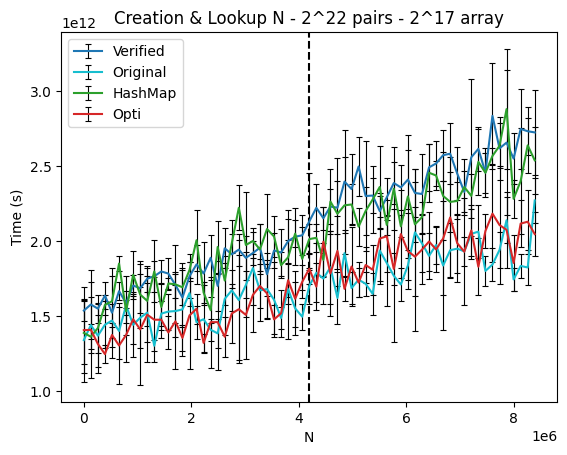

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


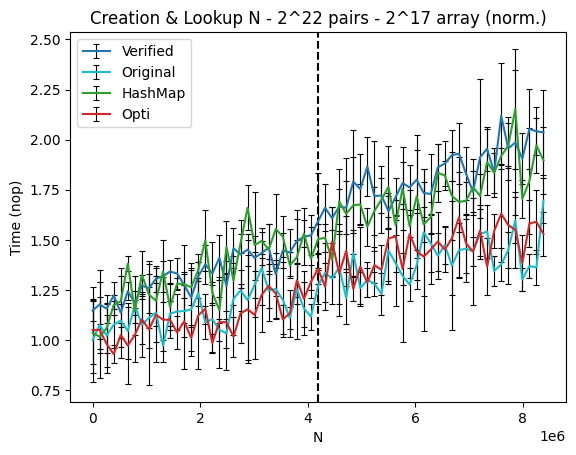

MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


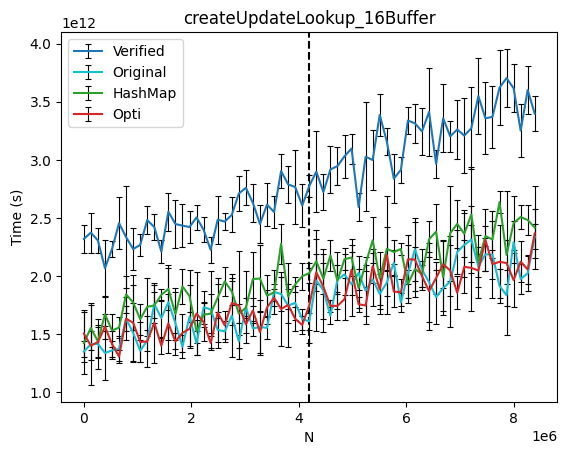

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


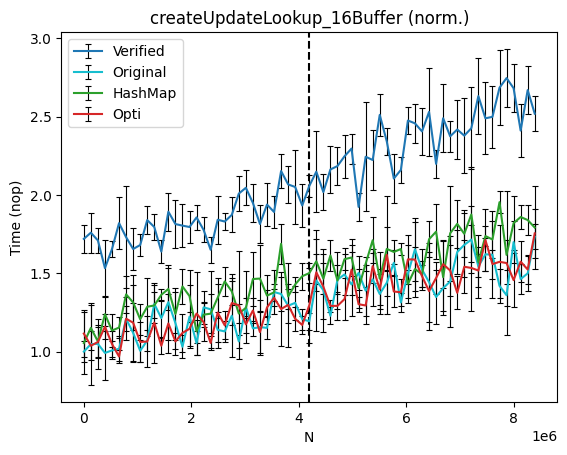

MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


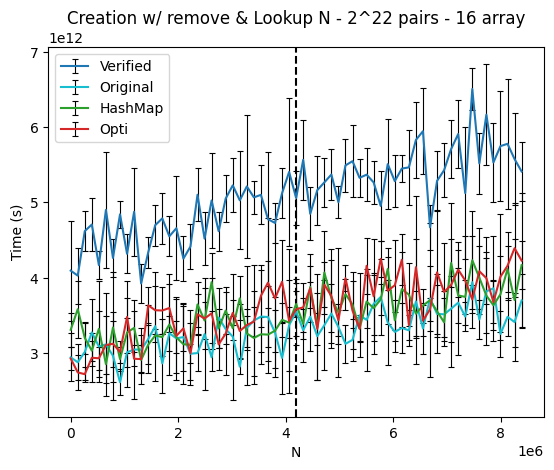

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


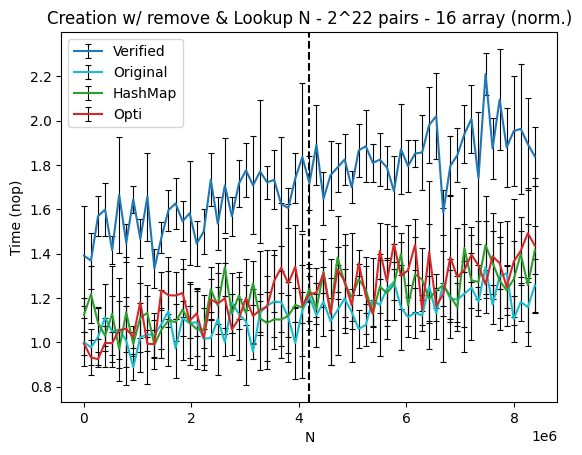

MutableLongMapBenchmarkBig.lookupN


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


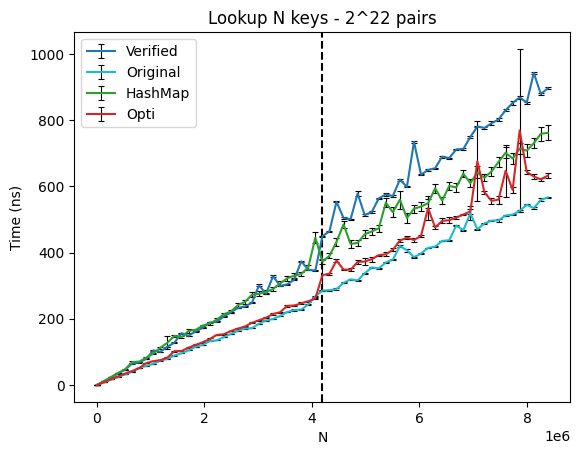

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


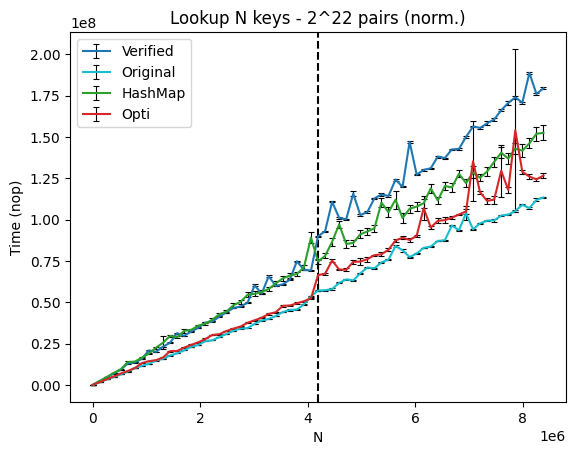

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


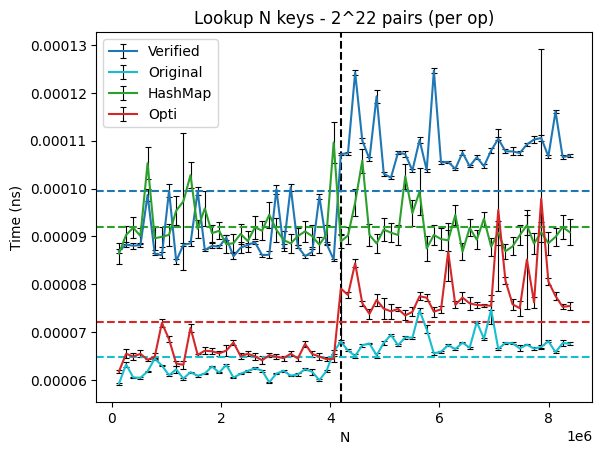

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


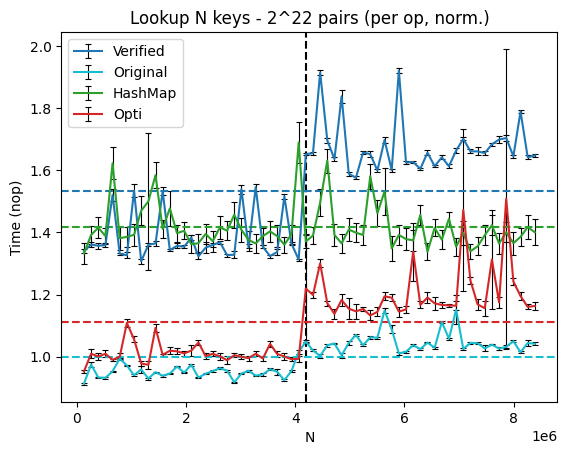

In [14]:
data="""[info] Benchmark                                                                    (nKeys)  Mode  Cnt        Score         Error  Units
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                        0  avgt   10     2230.910 ±      38.877  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     1024  avgt   10     2141.691 ±      14.166  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     2048  avgt   10     2166.790 ±      20.854  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     3072  avgt   10     2268.670 ±      20.800  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     4096  avgt   10     2122.935 ±       9.814  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     5120  avgt   10     2176.401 ±      11.876  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     6144  avgt   10     2259.647 ±      11.973  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     7168  avgt   10     2352.556 ±       6.660  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     8192  avgt   10     2185.506 ±      20.142  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                     9216  avgt   10     2321.404 ±      10.459  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    10240  avgt   10     2264.748 ±      28.726  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    11264  avgt   10     2271.556 ±      27.622  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    12288  avgt   10     2380.728 ±      22.118  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    13312  avgt   10     2323.063 ±      10.488  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    14336  avgt   10     2403.684 ±       9.947  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    15360  avgt   10     2311.434 ±      23.836  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    16384  avgt   10     2422.332 ±      12.720  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    17408  avgt   10     2374.896 ±      13.681  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    18432  avgt   10     2492.873 ±      27.528  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    19456  avgt   10     2444.276 ±      28.052  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    20480  avgt   10     2385.685 ±      21.513  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    21504  avgt   10     2493.848 ±      13.263  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    22528  avgt   10     2524.509 ±      18.391  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    23552  avgt   10     2493.760 ±      12.024  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    24576  avgt   10     2493.448 ±      16.210  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    25600  avgt   10     2575.615 ±      11.321  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    26624  avgt   10     2576.370 ±      14.817  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    27648  avgt   10     2575.004 ±      13.759  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    28672  avgt   10     2606.674 ±      19.232  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    29696  avgt   10     2633.313 ±      22.279  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    30720  avgt   10     2626.641 ±      26.393  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    31744  avgt   10     2556.627 ±      29.066  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    32768  avgt   10     2679.013 ±      21.598  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    33792  avgt   10     2693.469 ±      41.114  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    34816  avgt   10     2734.284 ±      17.250  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    35840  avgt   10     2727.471 ±      12.340  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    36864  avgt   10     2709.878 ±      24.551  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    37888  avgt   10     2641.869 ±      21.793  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    38912  avgt   10     2774.863 ±      13.128  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    39936  avgt   10     2797.899 ±      12.629  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    40960  avgt   10     2780.802 ±      20.492  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    41984  avgt   10     2826.959 ±      17.361  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    43008  avgt   10     2879.852 ±      17.815  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    44032  avgt   10     2792.497 ±      13.071  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    45056  avgt   10     2745.327 ±      21.108  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    46080  avgt   10     2839.932 ±      16.855  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    47104  avgt   10     2757.347 ±      11.962  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    48128  avgt   10     2969.971 ±      39.102  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    49152  avgt   10     2969.876 ±     141.094  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    50176  avgt   10     2906.926 ±      30.237  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    51200  avgt   10     2919.148 ±      28.091  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    52224  avgt   10     2977.104 ±      23.485  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    53248  avgt   10     2966.334 ±      30.048  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    54272  avgt   10     2979.003 ±      33.975  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    55296  avgt   10     3095.457 ±      13.693  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    56320  avgt   10     3026.573 ±      12.097  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    57344  avgt   10     3069.109 ±      15.646  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    58368  avgt   10     3106.951 ±      13.564  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    59392  avgt   10     3087.247 ±      28.985  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    60416  avgt   10     3041.332 ±      16.628  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    61440  avgt   10     3119.283 ±      30.618  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    62464  avgt   10     2965.918 ±      21.688  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    63488  avgt   10     3061.994 ±      12.563  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    64512  avgt   10     3138.144 ±      13.327  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_HashMap                    65536  avgt   10     3240.322 ±      14.092  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                           0  avgt   10     2529.641 ±      11.946  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        1024  avgt   10     2558.875 ±      14.464  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        2048  avgt   10     2597.056 ±       9.309  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        3072  avgt   10     2587.898 ±      21.582  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        4096  avgt   10     2642.335 ±      20.110  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        5120  avgt   10     2603.137 ±      20.888  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        6144  avgt   10     2642.781 ±       8.858  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        7168  avgt   10     2685.512 ±      18.105  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        8192  avgt   10     2651.908 ±      20.816  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                        9216  avgt   10     2696.729 ±      11.118  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       10240  avgt   10     2686.536 ±      16.844  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       11264  avgt   10     2716.860 ±      14.589  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       12288  avgt   10     2716.758 ±      13.739  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       13312  avgt   10     2770.787 ±      28.179  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       14336  avgt   10     2760.996 ±      15.492  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       15360  avgt   10     2766.907 ±      17.312  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       16384  avgt   10     2794.426 ±       9.130  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       17408  avgt   10     2816.113 ±      16.420  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       18432  avgt   10     2864.998 ±      18.284  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       19456  avgt   10     2829.923 ±      14.046  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       20480  avgt   10     2851.188 ±       8.238  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       21504  avgt   10     2882.622 ±      16.888  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       22528  avgt   10     2909.841 ±      13.168  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       23552  avgt   10     2914.602 ±      23.136  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       24576  avgt   10     2963.933 ±      21.296  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       25600  avgt   10     2954.339 ±      16.224  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       26624  avgt   10     3042.707 ±      17.252  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       27648  avgt   10     3029.757 ±      22.307  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       28672  avgt   10     3066.984 ±      37.209  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       29696  avgt   10     3061.633 ±      53.565  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       30720  avgt   10     3068.068 ±      47.188  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       31744  avgt   10     3101.656 ±      44.985  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       32768  avgt   10     3131.513 ±      30.600  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       33792  avgt   10     3114.642 ±      25.908  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       34816  avgt   10     3143.662 ±      20.035  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       35840  avgt   10     3185.560 ±      23.156  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       36864  avgt   10     3202.211 ±      20.476  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       37888  avgt   10     3234.160 ±      28.646  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       38912  avgt   10     3244.988 ±      29.769  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       39936  avgt   10     3242.559 ±      22.453  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       40960  avgt   10     3232.121 ±      47.001  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       41984  avgt   10     3174.873 ±       9.693  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       43008  avgt   10     3251.135 ±      17.351  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       44032  avgt   10     3265.543 ±      19.088  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       45056  avgt   10     3262.510 ±      11.169  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       46080  avgt   10     3306.069 ±      24.300  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       47104  avgt   10     3290.495 ±      11.466  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       48128  avgt   10     3257.229 ±      13.265  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       49152  avgt   10     3327.422 ±      24.982  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       50176  avgt   10     3354.192 ±      10.476  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       51200  avgt   10     3353.937 ±      21.696  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       52224  avgt   10     3397.332 ±      23.349  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       53248  avgt   10     3440.202 ±      31.763  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       54272  avgt   10     3355.557 ±      27.252  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       55296  avgt   10     3448.660 ±      33.605  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       56320  avgt   10     3461.202 ±      26.164  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       57344  avgt   10     3496.011 ±      24.211  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       58368  avgt   10     3501.821 ±      17.000  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       59392  avgt   10     3519.091 ±      34.329  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       60416  avgt   10     3516.835 ±      25.376  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       61440  avgt   10     3530.865 ±      31.943  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       62464  avgt   10     3529.666 ±      31.196  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       63488  avgt   10     3547.567 ±      15.424  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       64512  avgt   10     3580.377 ±      19.731  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Opti                       65536  avgt   10     3654.555 ±      28.196  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                       0  avgt   10     2165.825 ±      18.964  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    1024  avgt   10     2248.015 ±      25.850  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    2048  avgt   10     2200.944 ±      21.457  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    3072  avgt   10     2312.344 ±       9.540  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    4096  avgt   10     2309.568 ±      25.761  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    5120  avgt   10     2290.954 ±      19.223  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    6144  avgt   10     2263.705 ±       8.212  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    7168  avgt   10     2317.701 ±      13.984  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    8192  avgt   10     2281.803 ±      21.463  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                    9216  avgt   10     2349.723 ±      17.421  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   10240  avgt   10     2311.590 ±       9.649  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   11264  avgt   10     2412.094 ±       9.515  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   12288  avgt   10     2424.979 ±      18.591  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   13312  avgt   10     2453.816 ±      16.014  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   14336  avgt   10     2409.313 ±       8.318  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   15360  avgt   10     2480.336 ±      22.223  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   16384  avgt   10     2397.402 ±      14.075  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   17408  avgt   10     2501.368 ±       9.126  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   18432  avgt   10     2525.496 ±      11.167  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   19456  avgt   10     2489.878 ±       8.941  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   20480  avgt   10     2506.055 ±       8.911  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   21504  avgt   10     2583.031 ±       9.593  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   22528  avgt   10     2626.510 ±       8.106  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   23552  avgt   10     2576.784 ±      11.710  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   24576  avgt   10     2572.417 ±      24.440  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   25600  avgt   10     2647.913 ±      20.921  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   26624  avgt   10     2612.062 ±      16.372  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   27648  avgt   10     2649.063 ±      12.440  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   28672  avgt   10     2661.042 ±      26.852  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   29696  avgt   10     2682.009 ±      11.828  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   30720  avgt   10     2654.174 ±      19.003  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   31744  avgt   10     2701.937 ±      28.713  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   32768  avgt   10     2686.780 ±      25.874  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   33792  avgt   10     2725.756 ±      20.683  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   34816  avgt   10     2742.347 ±      13.716  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   35840  avgt   10     2771.455 ±      21.217  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   36864  avgt   10     2791.652 ±      20.912  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   37888  avgt   10     2800.768 ±      18.228  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   38912  avgt   10     2789.729 ±      11.390  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   39936  avgt   10     2830.062 ±      24.196  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   40960  avgt   10     2865.516 ±      12.087  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   41984  avgt   10     2829.042 ±       8.130  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   43008  avgt   10     2858.078 ±      26.521  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   44032  avgt   10     2918.638 ±      24.266  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   45056  avgt   10     2841.885 ±      10.060  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   46080  avgt   10     2920.856 ±      11.419  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   47104  avgt   10     2907.632 ±      16.025  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   48128  avgt   10     2984.108 ±      24.203  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   49152  avgt   10     2962.270 ±      16.977  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   50176  avgt   10     3011.203 ±      22.451  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   51200  avgt   10     3010.784 ±      10.280  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   52224  avgt   10     3001.013 ±      14.145  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   53248  avgt   10     3003.871 ±      15.228  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   54272  avgt   10     3015.415 ±      17.166  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   55296  avgt   10     3083.691 ±      19.006  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   56320  avgt   10     3033.050 ±      19.637  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   57344  avgt   10     3087.475 ±      22.784  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   58368  avgt   10     3105.262 ±      12.344  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   59392  avgt   10     3051.771 ±      14.422  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   60416  avgt   10     3121.838 ±      10.936  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   61440  avgt   10     3124.853 ±      16.082  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   62464  avgt   10     3183.649 ±      24.709  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   63488  avgt   10     3184.648 ±      14.882  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   64512  avgt   10     3205.570 ±      11.053  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Original                   65536  avgt   10     3186.602 ±      39.198  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                       0  avgt   10     3116.273 ±      16.072  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    1024  avgt   10     3149.044 ±      14.321  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    2048  avgt   10     3175.343 ±       5.620  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    3072  avgt   10     3213.052 ±      25.306  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    4096  avgt   10     3269.804 ±      23.447  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    5120  avgt   10     3235.788 ±      20.453  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    6144  avgt   10     3285.893 ±      28.136  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    7168  avgt   10     3303.281 ±      21.293  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    8192  avgt   10     3297.191 ±      42.535  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                    9216  avgt   10     3382.731 ±      21.788  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   10240  avgt   10     3348.789 ±      16.552  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   11264  avgt   10     3425.798 ±      14.573  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   12288  avgt   10     3427.094 ±      14.269  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   13312  avgt   10     3437.077 ±      37.399  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   14336  avgt   10     3496.856 ±      16.109  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   15360  avgt   10     3487.755 ±      18.782  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   16384  avgt   10     3506.315 ±      16.118  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   17408  avgt   10     3526.723 ±      19.684  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   18432  avgt   10     3573.619 ±      30.393  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   19456  avgt   10     3542.184 ±      30.243  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   20480  avgt   10     3642.537 ±      22.970  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   21504  avgt   10     3621.207 ±      27.994  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   22528  avgt   10     3629.415 ±      12.716  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   23552  avgt   10     3640.063 ±      31.512  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   24576  avgt   10     3702.052 ±      29.579  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   25600  avgt   10     3730.961 ±      27.385  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   26624  avgt   10     3722.011 ±      18.140  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   27648  avgt   10     3734.265 ±      21.466  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   28672  avgt   10     3765.558 ±      15.231  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   29696  avgt   10     3850.900 ±      43.767  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   30720  avgt   10     3820.548 ±      31.466  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   31744  avgt   10     3838.642 ±      33.870  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   32768  avgt   10     3890.145 ±      15.913  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   33792  avgt   10     3907.660 ±      20.517  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   34816  avgt   10     3938.245 ±      20.123  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   35840  avgt   10     3931.246 ±      43.197  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   36864  avgt   10     3997.190 ±      40.581  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   37888  avgt   10     3991.918 ±      29.079  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   38912  avgt   10     4025.317 ±      28.754  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   39936  avgt   10     4054.088 ±      25.297  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   40960  avgt   10     4062.603 ±      18.094  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   41984  avgt   10     4111.431 ±      16.901  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   43008  avgt   10     4071.422 ±      23.192  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   44032  avgt   10     4157.742 ±      34.501  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   45056  avgt   10     4086.570 ±      16.651  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   46080  avgt   10     4133.287 ±      48.094  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   47104  avgt   10     4213.782 ±      19.552  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   48128  avgt   10     4208.087 ±      20.041  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   49152  avgt   10     4244.163 ±      28.122  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   50176  avgt   10     4298.784 ±      21.816  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   51200  avgt   10     4243.742 ±      21.352  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   52224  avgt   10     4325.352 ±      32.443  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   53248  avgt   10     4349.852 ±      36.634  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   54272  avgt   10     4285.703 ±      18.052  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   55296  avgt   10     4319.193 ±      27.420  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   56320  avgt   10     4365.717 ±      40.369  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   57344  avgt   10     4448.501 ±      30.530  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   58368  avgt   10     4456.903 ±      53.141  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   59392  avgt   10     4434.025 ±      19.104  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   60416  avgt   10     4506.417 ±      56.029  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   61440  avgt   10     4500.103 ±      18.960  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   62464  avgt   10     4609.294 ±      50.968  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   63488  avgt   10     4547.195 ±      42.374  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   64512  avgt   10     4571.199 ±      31.033  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_16Buffer_Verified                   65536  avgt   10     4550.676 ±      38.286  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                     0  avgt   10     2151.450 ±      14.212  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  1024  avgt   10     2173.940 ±      11.172  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  2048  avgt   10     2070.901 ±       9.816  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  3072  avgt   10     2124.196 ±      11.759  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  4096  avgt   10     2186.686 ±      16.899  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  5120  avgt   10     2183.218 ±      18.003  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  6144  avgt   10     2210.149 ±      15.236  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  7168  avgt   10     2176.664 ±      13.025  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  8192  avgt   10     2288.483 ±      12.502  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                  9216  avgt   10     2299.530 ±      16.033  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 10240  avgt   10     2247.295 ±      26.642  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 11264  avgt   10     2330.548 ±      14.366  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 12288  avgt   10     2291.961 ±      14.402  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 13312  avgt   10     2405.959 ±      14.245  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 14336  avgt   10     2324.829 ±      29.635  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 15360  avgt   10     2386.759 ±      16.634  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 16384  avgt   10     2434.044 ±      15.444  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 17408  avgt   10     2379.034 ±      27.600  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 18432  avgt   10     2384.594 ±      17.175  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 19456  avgt   10     2486.697 ±      26.952  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 20480  avgt   10     2430.960 ±      25.720  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 21504  avgt   10     2396.208 ±      15.859  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 22528  avgt   10     2546.959 ±      21.525  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 23552  avgt   10     2614.496 ±     174.366  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 24576  avgt   10     2470.402 ±      16.655  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 25600  avgt   10     2493.670 ±      10.890  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 26624  avgt   10     2609.814 ±      18.469  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 27648  avgt   10     2599.588 ±      20.693  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 28672  avgt   10     2492.151 ±      14.955  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 29696  avgt   10     2626.554 ±       8.332  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 30720  avgt   10     2585.882 ±      16.623  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 31744  avgt   10     2659.714 ±      13.962  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 32768  avgt   10     2613.110 ±      24.818  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 33792  avgt   10     2739.314 ±      20.495  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 34816  avgt   10     2761.062 ±      16.789  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 35840  avgt   10     2731.685 ±      25.367  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 36864  avgt   10     2758.783 ±      23.340  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 37888  avgt   10     2792.594 ±      23.268  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 38912  avgt   10     2735.802 ±      15.050  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 39936  avgt   10     2848.010 ±      16.889  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 40960  avgt   10     2840.448 ±      27.809  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 41984  avgt   10     2827.454 ±      12.464  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 43008  avgt   10     2876.551 ±      21.689  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 44032  avgt   10     2836.372 ±      16.061  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 45056  avgt   10     2845.260 ±      33.654  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 46080  avgt   10     2947.623 ±      16.127  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 47104  avgt   10     2912.296 ±      27.459  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 48128  avgt   10     2948.757 ±      11.258  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 49152  avgt   10     2960.911 ±      24.909  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 50176  avgt   10     2945.565 ±      36.524  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 51200  avgt   10     2981.765 ±      13.637  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 52224  avgt   10     3040.585 ±      17.318  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 53248  avgt   10     3031.219 ±      27.447  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 54272  avgt   10     3005.069 ±      27.365  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 55296  avgt   10     3008.134 ±      21.679  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 56320  avgt   10     3034.586 ±      33.728  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 57344  avgt   10     3065.088 ±      16.198  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 58368  avgt   10     3080.236 ±      42.935  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 59392  avgt   10     3094.108 ±      14.457  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 60416  avgt   10     3123.648 ±      21.778  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 61440  avgt   10     3207.089 ±      20.658  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 62464  avgt   10     3125.577 ±      27.929  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 63488  avgt   10     3186.771 ±      26.223  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 64512  avgt   10     3159.484 ±      11.751  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_HashMap                 65536  avgt   10     3161.306 ±      35.877  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                        0  avgt   10     1459.575 ±       7.075  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     1024  avgt   10     1443.825 ±       5.456  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     2048  avgt   10     1478.346 ±      20.043  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     3072  avgt   10     1478.149 ±      19.600  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     4096  avgt   10     1530.085 ±      12.424  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     5120  avgt   10     1534.989 ±      13.254  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     6144  avgt   10     1541.567 ±      19.605  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     7168  avgt   10     1576.584 ±      18.893  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     8192  avgt   10     1574.301 ±      11.565  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                     9216  avgt   10     1567.539 ±       7.013  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    10240  avgt   10     1587.373 ±       8.844  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    11264  avgt   10     1608.318 ±      17.207  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    12288  avgt   10     1644.709 ±      20.259  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    13312  avgt   10     1617.792 ±      20.076  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    14336  avgt   10     1688.032 ±       7.320  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    15360  avgt   10     1726.466 ±      26.056  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    16384  avgt   10     1651.901 ±      24.349  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    17408  avgt   10     1742.809 ±      50.762  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    18432  avgt   10     1742.716 ±      18.417  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    19456  avgt   10     1736.208 ±      27.497  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    20480  avgt   10     1742.412 ±      19.767  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    21504  avgt   10     1753.845 ±      19.809  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    22528  avgt   10     1784.087 ±      20.251  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    23552  avgt   10     1809.038 ±      19.443  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    24576  avgt   10     1821.753 ±      36.246  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    25600  avgt   10     1843.262 ±      14.541  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    26624  avgt   10     1848.179 ±       8.660  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    27648  avgt   10     1819.855 ±      47.464  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    28672  avgt   10     1913.123 ±      19.615  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    29696  avgt   10     1866.311 ±      20.586  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    30720  avgt   10     1969.076 ±      35.156  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    31744  avgt   10     1907.375 ±      13.719  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    32768  avgt   10     1969.413 ±       9.026  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    33792  avgt   10     1974.043 ±       8.775  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    34816  avgt   10     2002.912 ±       8.209  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    35840  avgt   10     1984.710 ±       8.881  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    36864  avgt   10     1974.921 ±      20.909  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    37888  avgt   10     1981.213 ±      32.355  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    38912  avgt   10     2007.649 ±      19.588  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    39936  avgt   10     2051.588 ±      16.439  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    40960  avgt   10     2043.612 ±      14.477  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    41984  avgt   10     2058.894 ±      18.599  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    43008  avgt   10     2103.950 ±       9.072  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    44032  avgt   10     2063.855 ±      20.415  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    45056  avgt   10     2128.907 ±      10.410  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    46080  avgt   10     2172.410 ±      14.362  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    47104  avgt   10     2055.656 ±      10.246  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    48128  avgt   10     2139.288 ±      25.939  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    49152  avgt   10     2214.429 ±       9.996  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    50176  avgt   10     2201.257 ±      10.636  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    51200  avgt   10     2132.593 ±      14.888  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    52224  avgt   10     2229.352 ±       9.679  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    53248  avgt   10     2274.355 ±      22.007  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    54272  avgt   10     2179.672 ±      10.692  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    55296  avgt   10     2219.063 ±      16.494  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    56320  avgt   10     2212.470 ±      10.495  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    57344  avgt   10     2248.565 ±      11.342  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    58368  avgt   10     2247.864 ±      18.015  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    59392  avgt   10     2238.391 ±      19.707  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    60416  avgt   10     2314.335 ±      19.530  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    61440  avgt   10     2355.030 ±      12.472  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    62464  avgt   10     2281.989 ±       6.104  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    63488  avgt   10     2319.698 ±      32.002  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    64512  avgt   10     2354.952 ±      17.391  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Opti                    65536  avgt   10     2453.910 ±      18.497  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                    0  avgt   10     1561.868 ±      13.104  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 1024  avgt   10     1640.804 ±      15.387  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 2048  avgt   10     1546.318 ±      10.019  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 3072  avgt   10     1571.910 ±      22.705  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 4096  avgt   10     1614.033 ±       6.501  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 5120  avgt   10     1590.628 ±      12.876  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 6144  avgt   10     1615.493 ±      17.497  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 7168  avgt   10     1570.472 ±       7.451  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 8192  avgt   10     1606.773 ±      18.359  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                 9216  avgt   10     1680.031 ±       7.428  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                10240  avgt   10     1629.385 ±      11.783  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                11264  avgt   10     1644.937 ±      12.218  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                12288  avgt   10     1677.589 ±      10.993  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                13312  avgt   10     1662.554 ±      11.059  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                14336  avgt   10     1700.337 ±      11.173  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                15360  avgt   10     1716.843 ±      14.463  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                16384  avgt   10     1738.768 ±      15.978  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                17408  avgt   10     1744.154 ±       7.467  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                18432  avgt   10     1772.955 ±      18.861  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                19456  avgt   10     1759.590 ±      15.510  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                20480  avgt   10     1757.915 ±       5.579  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                21504  avgt   10     1802.857 ±      23.682  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                22528  avgt   10     1897.847 ±       6.792  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                23552  avgt   10     1810.717 ±      15.237  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                24576  avgt   10     1947.725 ±       8.634  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                25600  avgt   10     1954.106 ±       9.184  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                26624  avgt   10     1875.578 ±      11.475  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                27648  avgt   10     1967.497 ±      12.579  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                28672  avgt   10     1983.204 ±       7.369  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                29696  avgt   10     1998.046 ±      11.395  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                30720  avgt   10     1989.658 ±       7.949  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                31744  avgt   10     1920.608 ±      21.960  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                32768  avgt   10     1987.140 ±      16.779  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                33792  avgt   10     1992.101 ±      18.289  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                34816  avgt   10     2028.124 ±       7.938  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                35840  avgt   10     2070.484 ±      13.832  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                36864  avgt   10     2074.669 ±      21.178  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                37888  avgt   10     2052.068 ±       8.635  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                38912  avgt   10     2042.812 ±      16.233  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                39936  avgt   10     2110.653 ±      10.195  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                40960  avgt   10     2108.898 ±      10.011  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                41984  avgt   10     2130.776 ±      24.937  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                43008  avgt   10     2059.915 ±      23.156  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                44032  avgt   10     2133.617 ±      26.871  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                45056  avgt   10     2201.709 ±      17.734  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                46080  avgt   10     2144.986 ±      14.600  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                47104  avgt   10     2235.401 ±      29.281  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                48128  avgt   10     2171.566 ±      29.271  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                49152  avgt   10     2243.628 ±      35.555  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                50176  avgt   10     2211.574 ±      10.579  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                51200  avgt   10     2232.725 ±      49.342  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                52224  avgt   10     2208.660 ±      16.537  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                53248  avgt   10     2287.258 ±      31.793  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                54272  avgt   10     2290.706 ±      27.011  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                55296  avgt   10     2286.756 ±       9.484  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                56320  avgt   10     2297.198 ±      12.851  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                57344  avgt   10     2290.725 ±      19.045  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                58368  avgt   10     2314.164 ±       7.685  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                59392  avgt   10     2355.005 ±      17.613  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                60416  avgt   10     2387.407 ±       9.408  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                61440  avgt   10     2352.344 ±      18.364  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                62464  avgt   10     2337.591 ±       8.178  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                63488  avgt   10     2386.207 ±      10.342  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                64512  avgt   10     2412.061 ±      13.629  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Original                65536  avgt   10     2381.768 ±      13.334  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                    0  avgt   10     1910.062 ±      16.005  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 1024  avgt   10     1928.211 ±      10.943  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 2048  avgt   10     1917.494 ±      23.221  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 3072  avgt   10     1945.583 ±      12.780  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 4096  avgt   10     1955.496 ±      13.715  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 5120  avgt   10     1997.361 ±      15.242  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 6144  avgt   10     1975.875 ±      21.805  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 7168  avgt   10     2023.189 ±      20.706  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 8192  avgt   10     2101.249 ±      14.052  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                 9216  avgt   10     2093.101 ±      10.135  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                10240  avgt   10     2126.219 ±      10.076  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                11264  avgt   10     2111.014 ±       9.740  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                12288  avgt   10     2115.471 ±      22.091  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                13312  avgt   10     2172.671 ±      12.506  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                14336  avgt   10     2158.351 ±      28.830  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                15360  avgt   10     2190.027 ±      13.515  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                16384  avgt   10     2219.273 ±      29.463  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                17408  avgt   10     2227.187 ±      11.181  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                18432  avgt   10     2260.661 ±      12.179  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                19456  avgt   10     2285.738 ±      11.518  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                20480  avgt   10     2286.877 ±      11.354  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                21504  avgt   10     2301.264 ±      16.498  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                22528  avgt   10     2361.676 ±      15.838  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                23552  avgt   10     2364.933 ±      27.893  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                24576  avgt   10     2381.591 ±      22.437  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                25600  avgt   10     2384.788 ±      18.470  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                26624  avgt   10     2377.144 ±      19.492  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                27648  avgt   10     2459.888 ±      10.677  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                28672  avgt   10     2442.241 ±      21.083  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                29696  avgt   10     2474.233 ±      18.900  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                30720  avgt   10     2447.013 ±      19.980  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                31744  avgt   10     2491.095 ±      18.896  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                32768  avgt   10     2526.940 ±      14.406  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                33792  avgt   10     2588.967 ±      19.699  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                34816  avgt   10     2553.145 ±      24.860  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                35840  avgt   10     2543.781 ±      18.616  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                36864  avgt   10     2596.644 ±      11.941  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                37888  avgt   10     2666.057 ±      24.732  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                38912  avgt   10     2651.328 ±      16.328  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                39936  avgt   10     2654.715 ±      13.582  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                40960  avgt   10     2671.848 ±      17.083  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                41984  avgt   10     2676.990 ±      28.056  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                43008  avgt   10     2710.773 ±      31.699  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                44032  avgt   10     2756.773 ±      13.118  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                45056  avgt   10     2749.590 ±      14.351  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                46080  avgt   10     2790.791 ±      13.429  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                47104  avgt   10     2782.808 ±      18.402  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                48128  avgt   10     2787.737 ±      36.454  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                49152  avgt   10     2814.348 ±      17.257  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                50176  avgt   10     2899.040 ±      32.926  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                51200  avgt   10     2867.644 ±      20.995  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                52224  avgt   10     2933.060 ±       9.886  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                53248  avgt   10     2894.911 ±      34.572  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                54272  avgt   10     2908.142 ±      16.782  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                55296  avgt   10     2965.695 ±      29.397  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                56320  avgt   10     2971.440 ±      26.015  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                57344  avgt   10     3001.761 ±      13.603  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                58368  avgt   10     3017.933 ±      16.983  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                59392  avgt   10     3043.247 ±      25.287  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                60416  avgt   10     3051.547 ±      11.363  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                61440  avgt   10     3092.230 ±      13.589  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                62464  avgt   10     3083.344 ±      35.720  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                63488  avgt   10     3154.229 ±      15.531  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                64512  avgt   10     3124.455 ±      35.117  us/op
[info] MutableLongMapBenchmark.createUpdateLookup_2to17Buffer_Verified                65536  avgt   10     3120.141 ±      33.884  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap            0  avgt   10     4656.933 ±      26.613  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         1024  avgt   10     4521.312 ±      51.435  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         2048  avgt   10     4492.105 ±      34.483  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         3072  avgt   10     4554.848 ±      26.282  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         4096  avgt   10     4532.632 ±      39.254  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         5120  avgt   10     4576.813 ±      39.560  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         6144  avgt   10     4621.854 ±      36.397  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         7168  avgt   10     4592.677 ±      37.431  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         8192  avgt   10     4792.500 ±      51.272  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap         9216  avgt   10     4929.298 ±      31.285  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        10240  avgt   10     4616.180 ±      39.419  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        11264  avgt   10     4751.687 ±      68.484  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        12288  avgt   10     4851.901 ±      20.860  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        13312  avgt   10     4686.362 ±      36.316  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        14336  avgt   10     4874.938 ±      27.019  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        15360  avgt   10     4737.366 ±      20.235  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        16384  avgt   10     4680.504 ±      29.524  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        17408  avgt   10     4785.168 ±      25.023  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        18432  avgt   10     4899.651 ±      43.176  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        19456  avgt   10     4819.390 ±      24.416  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        20480  avgt   10     4904.318 ±      29.047  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        21504  avgt   10     4874.194 ±      56.682  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        22528  avgt   10     4912.591 ±      52.386  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        23552  avgt   10     4918.750 ±      20.932  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        24576  avgt   10     4854.353 ±      34.261  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        25600  avgt   10     4882.990 ±      47.519  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        26624  avgt   10     4842.114 ±      59.427  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        27648  avgt   10     4946.846 ±      28.452  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        28672  avgt   10     5053.483 ±      24.010  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        29696  avgt   10     4997.039 ±      26.609  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        30720  avgt   10     4995.580 ±      35.351  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        31744  avgt   10     5216.945 ±      28.619  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        32768  avgt   10     4988.523 ±      47.972  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        33792  avgt   10     5164.499 ±      42.184  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        34816  avgt   10     5250.236 ±      52.553  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        35840  avgt   10     5085.901 ±      56.859  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        36864  avgt   10     5167.815 ±      41.181  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        37888  avgt   10     5125.389 ±      65.505  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        38912  avgt   10     5112.010 ±      57.441  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        39936  avgt   10     5194.458 ±      29.408  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        40960  avgt   10     5162.014 ±      22.530  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        41984  avgt   10     5199.911 ±      53.833  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        43008  avgt   10     5259.882 ±      35.536  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        44032  avgt   10     5138.962 ±      53.948  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        45056  avgt   10     5231.243 ±      29.359  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        46080  avgt   10     5191.327 ±      30.185  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        47104  avgt   10     5328.569 ±      29.729  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        48128  avgt   10     5383.488 ±      32.943  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        49152  avgt   10     5338.210 ±      54.164  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        50176  avgt   10     5342.299 ±      64.943  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        51200  avgt   10     5356.446 ±      43.495  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        52224  avgt   10     5347.905 ±      37.739  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        53248  avgt   10     5364.533 ±      68.599  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        54272  avgt   10     5412.615 ±      40.523  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        55296  avgt   10     5350.168 ±      51.365  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        56320  avgt   10     5525.447 ±      35.583  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        57344  avgt   10     5515.961 ±      29.745  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        58368  avgt   10     5381.670 ±      30.960  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        59392  avgt   10     5512.174 ±      19.785  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        60416  avgt   10     5608.404 ±      55.822  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        61440  avgt   10     5568.118 ±      54.398  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        62464  avgt   10     5669.942 ±      23.952  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        63488  avgt   10     5682.828 ±      83.205  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        64512  avgt   10     5629.610 ±      38.653  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_HashMap        65536  avgt   10     5609.232 ±      37.220  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti               0  avgt   10     4488.048 ±      30.820  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            1024  avgt   10     4416.565 ±      33.055  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            2048  avgt   10     4546.021 ±      25.007  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            3072  avgt   10     4593.984 ±      40.251  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            4096  avgt   10     4510.635 ±      33.307  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            5120  avgt   10     4532.120 ±      25.132  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            6144  avgt   10     4603.875 ±      53.855  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            7168  avgt   10     4647.536 ±      22.012  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            8192  avgt   10     4660.866 ±      72.383  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti            9216  avgt   10     4679.680 ±      30.250  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           10240  avgt   10     4721.876 ±      56.350  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           11264  avgt   10     4787.124 ±      45.520  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           12288  avgt   10     4784.044 ±      40.384  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           13312  avgt   10     4775.250 ±      21.380  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           14336  avgt   10     4807.942 ±      53.334  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           15360  avgt   10     4883.559 ±      23.959  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           16384  avgt   10     4808.403 ±      26.243  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           17408  avgt   10     4842.059 ±      19.438  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           18432  avgt   10     4791.556 ±      19.330  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           19456  avgt   10     4876.562 ±      30.041  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           20480  avgt   10     4877.812 ±      14.857  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           21504  avgt   10     4984.327 ±      24.423  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           22528  avgt   10     4918.714 ±      22.765  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           23552  avgt   10     5031.460 ±      73.141  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           24576  avgt   10     5115.137 ±      61.568  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           25600  avgt   10     4988.887 ±      50.568  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           26624  avgt   10     5059.355 ±      19.980  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           27648  avgt   10     5078.337 ±      35.362  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           28672  avgt   10     5050.038 ±      46.734  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           29696  avgt   10     5227.196 ±      34.993  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           30720  avgt   10     5182.916 ±      57.999  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           31744  avgt   10     5068.897 ±      35.258  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           32768  avgt   10     5184.086 ±      51.596  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           33792  avgt   10     5202.513 ±      40.850  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           34816  avgt   10     5218.529 ±      17.602  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           35840  avgt   10     5219.580 ±      41.003  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           36864  avgt   10     5206.072 ±      17.972  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           37888  avgt   10     5294.889 ±      40.641  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           38912  avgt   10     5225.077 ±      41.286  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           39936  avgt   10     5328.503 ±      43.333  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           40960  avgt   10     5254.070 ±      50.635  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           41984  avgt   10     5241.928 ±      20.282  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           43008  avgt   10     5356.942 ±      43.771  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           44032  avgt   10     5336.524 ±      21.634  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           45056  avgt   10     5478.355 ±      26.420  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           46080  avgt   10     5328.693 ±      21.667  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           47104  avgt   10     5350.966 ±      32.260  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           48128  avgt   10     5410.104 ±      28.870  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           49152  avgt   10     5456.539 ±      36.877  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           50176  avgt   10     5461.991 ±      40.986  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           51200  avgt   10     5433.847 ±      22.681  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           52224  avgt   10     5447.142 ±      78.708  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           53248  avgt   10     5584.941 ±      44.346  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           54272  avgt   10     5489.154 ±      29.598  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           55296  avgt   10     5622.595 ±      49.698  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           56320  avgt   10     5581.966 ±      49.654  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           57344  avgt   10     5586.611 ±      38.567  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           58368  avgt   10     5612.389 ±      34.980  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           59392  avgt   10     5667.894 ±      27.027  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           60416  avgt   10     5782.510 ±      26.799  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           61440  avgt   10     5704.921 ±      32.444  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           62464  avgt   10     5758.579 ±      66.946  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           63488  avgt   10     5753.191 ±      42.857  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           64512  avgt   10     5716.990 ±      50.628  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Opti           65536  avgt   10     5802.522 ±      53.926  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original           0  avgt   10     4509.163 ±      21.516  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        1024  avgt   10     4458.869 ±      31.867  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        2048  avgt   10     4525.997 ±      35.991  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        3072  avgt   10     4617.693 ±      25.139  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        4096  avgt   10     4543.043 ±      19.376  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        5120  avgt   10     4560.726 ±      21.713  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        6144  avgt   10     4538.241 ±      46.259  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        7168  avgt   10     4632.295 ±      18.761  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        8192  avgt   10     4641.877 ±      33.503  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original        9216  avgt   10     4604.350 ±      18.934  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       10240  avgt   10     4632.902 ±      37.176  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       11264  avgt   10     4647.124 ±      23.614  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       12288  avgt   10     4684.750 ±      24.745  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       13312  avgt   10     4615.678 ±      31.903  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       14336  avgt   10     4702.202 ±      21.409  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       15360  avgt   10     4836.188 ±      24.688  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       16384  avgt   10     4721.924 ±      35.722  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       17408  avgt   10     4697.676 ±      20.955  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       18432  avgt   10     4680.107 ±      17.564  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       19456  avgt   10     4784.991 ±      55.745  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       20480  avgt   10     4848.053 ±      44.939  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       21504  avgt   10     4718.279 ±      44.470  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       22528  avgt   10     4759.969 ±      26.582  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       23552  avgt   10     4755.682 ±      36.160  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       24576  avgt   10     4830.038 ±      37.706  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       25600  avgt   10     4805.345 ±      46.962  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       26624  avgt   10     4868.401 ±      23.658  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       27648  avgt   10     4818.549 ±      43.220  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       28672  avgt   10     4869.613 ±      30.406  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       29696  avgt   10     4796.179 ±      36.240  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       30720  avgt   10     4920.246 ±      23.854  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       31744  avgt   10     4969.885 ±      40.420  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       32768  avgt   10     4849.389 ±      38.010  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       33792  avgt   10     4920.144 ±      22.441  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       34816  avgt   10     4920.965 ±      35.494  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       35840  avgt   10     4905.840 ±      23.221  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       36864  avgt   10     4928.860 ±      21.058  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       37888  avgt   10     4916.582 ±      26.697  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       38912  avgt   10     4995.729 ±      24.199  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       39936  avgt   10     4987.299 ±      72.955  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       40960  avgt   10     5027.238 ±      39.495  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       41984  avgt   10     4969.578 ±      65.940  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       43008  avgt   10     5025.651 ±      42.930  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       44032  avgt   10     5048.290 ±      46.326  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       45056  avgt   10     5089.023 ±      92.262  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       46080  avgt   10     5031.065 ±      22.130  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       47104  avgt   10     5021.783 ±      19.666  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       48128  avgt   10     5068.734 ±      55.977  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       49152  avgt   10     5056.720 ±      24.102  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       50176  avgt   10     5082.019 ±      29.015  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       51200  avgt   10     5169.037 ±      42.691  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       52224  avgt   10     5067.379 ±      28.127  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       53248  avgt   10     5183.050 ±      34.344  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       54272  avgt   10     5041.131 ±      23.569  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       55296  avgt   10     5110.694 ±      26.136  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       56320  avgt   10     5251.606 ±      22.330  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       57344  avgt   10     5172.693 ±      24.851  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       58368  avgt   10     5311.124 ±      27.331  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       59392  avgt   10     5244.292 ±      37.308  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       60416  avgt   10     5227.138 ±      30.207  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       61440  avgt   10     5228.727 ±      42.354  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       62464  avgt   10     5241.289 ±      63.455  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       63488  avgt   10     5211.541 ±      24.779  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       64512  avgt   10     5282.604 ±      22.834  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Original       65536  avgt   10     5611.561 ±      75.309  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified           0  avgt   10     5781.068 ±      64.345  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        1024  avgt   10     5882.341 ±      41.321  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        2048  avgt   10     5929.778 ±      79.410  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        3072  avgt   10     5881.138 ±      42.814  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        4096  avgt   10     5922.836 ±      41.745  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        5120  avgt   10     5986.829 ±      25.141  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        6144  avgt   10     6000.723 ±      24.002  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        7168  avgt   10     6005.852 ±      31.712  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        8192  avgt   10     6068.511 ±      79.355  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified        9216  avgt   10     6030.213 ±      34.692  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       10240  avgt   10     6183.966 ±      37.668  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       11264  avgt   10     6130.491 ±      31.158  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       12288  avgt   10     6158.469 ±      63.990  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       13312  avgt   10     6243.153 ±      36.429  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       14336  avgt   10     6267.442 ±      53.788  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       15360  avgt   10     6219.019 ±      26.126  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       16384  avgt   10     6275.048 ±      65.829  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       17408  avgt   10     6334.974 ±      56.973  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       18432  avgt   10     6421.300 ±      72.736  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       19456  avgt   10     6417.993 ±      24.836  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       20480  avgt   10     6464.846 ±      32.744  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       21504  avgt   10     6461.096 ±      52.078  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       22528  avgt   10     6573.383 ±      81.461  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       23552  avgt   10     6433.360 ±      31.816  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       24576  avgt   10     6549.452 ±      35.053  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       25600  avgt   10     6511.390 ±      68.516  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       26624  avgt   10     6630.388 ±      68.917  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       27648  avgt   10     6672.637 ±      31.471  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       28672  avgt   10     6667.153 ±     101.653  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       29696  avgt   10     6565.442 ±      25.941  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       30720  avgt   10     6708.139 ±      71.152  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       31744  avgt   10     6761.203 ±      58.784  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       32768  avgt   10     6734.380 ±      97.706  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       33792  avgt   10     6833.685 ±      57.373  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       34816  avgt   10     6865.771 ±      45.031  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       35840  avgt   10     6734.333 ±      32.272  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       36864  avgt   10     6824.494 ±      56.227  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       37888  avgt   10     6903.203 ±      60.385  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       38912  avgt   10     6955.396 ±      33.835  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       39936  avgt   10     6904.556 ±      74.123  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       40960  avgt   10     7019.674 ±      77.283  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       41984  avgt   10     6919.370 ±      41.522  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       43008  avgt   10     6878.650 ±      50.854  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       44032  avgt   10     6928.672 ±      77.598  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       45056  avgt   10     6945.629 ±      88.193  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       46080  avgt   10     7031.288 ±      88.968  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       47104  avgt   10     7031.185 ±      37.222  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       48128  avgt   10     7137.819 ±      24.584  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       49152  avgt   10     7161.297 ±      85.244  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       50176  avgt   10     7150.298 ±      60.608  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       51200  avgt   10     7224.340 ±      50.067  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       52224  avgt   10     7318.128 ±      41.536  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       53248  avgt   10     7209.426 ±      75.611  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       54272  avgt   10     7173.066 ±      81.014  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       55296  avgt   10     7149.101 ±      64.718  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       56320  avgt   10     7303.380 ±      78.470  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       57344  avgt   10     7211.829 ±      44.473  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       58368  avgt   10     7289.778 ±      40.103  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       59392  avgt   10     7346.702 ±      41.859  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       60416  avgt   10     7392.059 ±      28.195  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       61440  avgt   10     7328.625 ±      35.779  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       62464  avgt   10     7428.006 ±      80.685  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       63488  avgt   10     7348.216 ±      35.873  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       64512  avgt   10     7448.539 ±      53.586  us/op
[info] MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer_Verified       65536  avgt   10     7564.716 ±      51.769  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                            0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         1024  avgt   10       13.291 ±       0.066  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         2048  avgt   10       31.621 ±       0.282  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         3072  avgt   10       47.660 ±       0.193  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         4096  avgt   10       62.139 ±       0.656  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         5120  avgt   10       83.625 ±       0.407  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         6144  avgt   10      101.867 ±       0.752  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         7168  avgt   10      117.028 ±       1.459  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         8192  avgt   10      134.725 ±       0.605  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                         9216  avgt   10      149.975 ±       0.610  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        10240  avgt   10      169.867 ±       0.984  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        11264  avgt   10      183.145 ±       1.162  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        12288  avgt   10      204.467 ±       2.405  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        13312  avgt   10      221.200 ±       1.153  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        14336  avgt   10      240.387 ±       0.930  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        15360  avgt   10      254.854 ±       2.397  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        16384  avgt   10      281.870 ±      12.377  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        17408  avgt   10      290.241 ±       2.637  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        18432  avgt   10      304.818 ±       1.998  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        19456  avgt   10      323.447 ±       1.720  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        20480  avgt   10      336.905 ±       1.860  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        21504  avgt   10      352.618 ±      11.508  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        22528  avgt   10      367.123 ±       1.525  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        23552  avgt   10      388.418 ±       4.754  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        24576  avgt   10      404.199 ±       8.404  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        25600  avgt   10      422.920 ±       2.745  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        26624  avgt   10      442.694 ±       3.910  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        27648  avgt   10      457.892 ±       2.398  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        28672  avgt   10      475.649 ±       3.610  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        29696  avgt   10      499.884 ±       2.121  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        30720  avgt   10      498.300 ±       2.651  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        31744  avgt   10      527.277 ±       2.916  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        32768  avgt   10      534.802 ±       9.475  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        33792  avgt   10      559.466 ±       5.584  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        34816  avgt   10      566.438 ±       2.648  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        35840  avgt   10      596.304 ±      26.373  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        36864  avgt   10      609.557 ±       8.236  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        37888  avgt   10      614.082 ±       2.050  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        38912  avgt   10      634.379 ±       3.811  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        39936  avgt   10      677.568 ±       4.900  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        40960  avgt   10      666.638 ±       7.558  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        41984  avgt   10      698.313 ±       3.040  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        43008  avgt   10      712.438 ±       6.336  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        44032  avgt   10      730.291 ±       7.606  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        45056  avgt   10      749.459 ±       4.469  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        46080  avgt   10      748.652 ±       4.816  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        47104  avgt   10      765.321 ±       3.887  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        48128  avgt   10      788.728 ±       9.748  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        49152  avgt   10      828.436 ±      38.179  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        50176  avgt   10      826.520 ±       3.265  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        51200  avgt   10      846.593 ±       3.874  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        52224  avgt   10      864.768 ±       6.943  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        53248  avgt   10      872.573 ±      14.185  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        54272  avgt   10      900.266 ±       8.341  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        55296  avgt   10      901.424 ±       3.911  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        56320  avgt   10      940.324 ±      54.113  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        57344  avgt   10      942.477 ±      19.827  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        58368  avgt   10      956.198 ±      25.210  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        59392  avgt   10      962.748 ±      16.311  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        60416  avgt   10     1001.905 ±      22.439  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        61440  avgt   10     1005.464 ±      28.026  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        62464  avgt   10     1015.267 ±      24.344  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        63488  avgt   10     1032.610 ±      23.403  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        64512  avgt   10     1039.469 ±      12.884  us/op
[info] MutableLongMapBenchmark.lookupN_HashMap                                        65536  avgt   10     1096.048 ±      48.607  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                               0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            1024  avgt   10       11.084 ±       0.035  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            2048  avgt   10       27.254 ±       0.047  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            3072  avgt   10       43.920 ±       0.395  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            4096  avgt   10       60.726 ±       0.390  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            5120  avgt   10       77.713 ±       0.173  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            6144  avgt   10       95.140 ±       0.100  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            7168  avgt   10      112.631 ±       0.105  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            8192  avgt   10      129.779 ±       0.828  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                            9216  avgt   10      144.311 ±       0.388  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           10240  avgt   10      161.741 ±       0.440  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           11264  avgt   10      183.570 ±       0.427  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           12288  avgt   10      193.997 ±       0.262  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           13312  avgt   10      214.420 ±       0.509  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           14336  avgt   10      234.788 ±       0.406  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           15360  avgt   10      247.320 ±       1.235  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           16384  avgt   10      262.144 ±       0.340  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           17408  avgt   10      279.127 ±       0.344  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           18432  avgt   10      294.838 ±       0.386  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           19456  avgt   10      323.126 ±       1.393  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           20480  avgt   10      334.564 ±       0.558  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           21504  avgt   10      353.089 ±       0.467  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           22528  avgt   10      360.282 ±       0.415  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           23552  avgt   10      387.594 ±       1.523  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           24576  avgt   10      397.353 ±      11.110  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           25600  avgt   10      420.810 ±       2.160  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           26624  avgt   10      444.606 ±       3.056  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           27648  avgt   10      454.138 ±       0.427  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           28672  avgt   10      465.879 ±       0.440  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           29696  avgt   10      483.827 ±       0.708  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           30720  avgt   10      509.293 ±       1.625  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           31744  avgt   10      514.514 ±       0.542  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           32768  avgt   10      536.035 ±       0.552  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           33792  avgt   10      551.749 ±       0.959  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           34816  avgt   10      577.679 ±       0.812  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           35840  avgt   10      587.997 ±       0.575  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           36864  avgt   10      606.063 ±       2.485  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           37888  avgt   10      617.341 ±       3.110  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           38912  avgt   10      623.487 ±       0.871  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           39936  avgt   10      648.928 ±       0.655  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           40960  avgt   10      655.180 ±       1.004  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           41984  avgt   10      680.862 ±       2.308  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           43008  avgt   10      719.797 ±       4.256  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           44032  avgt   10      728.611 ±       3.625  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           45056  avgt   10      730.358 ±       3.364  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           46080  avgt   10      759.700 ±       1.810  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           47104  avgt   10      769.975 ±       2.386  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           48128  avgt   10      784.112 ±       4.551  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           49152  avgt   10      812.184 ±       1.456  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           50176  avgt   10      816.330 ±       3.238  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           51200  avgt   10      831.329 ±       0.479  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           52224  avgt   10      849.859 ±       6.327  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           53248  avgt   10      883.612 ±       1.908  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           54272  avgt   10      899.338 ±       2.509  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           55296  avgt   10      910.002 ±       1.642  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           56320  avgt   10      931.415 ±       3.344  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           57344  avgt   10      930.986 ±       3.942  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           58368  avgt   10      945.962 ±       6.184  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           59392  avgt   10      988.544 ±      11.222  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           60416  avgt   10      981.890 ±       4.619  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           61440  avgt   10     1003.691 ±      10.455  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           62464  avgt   10     1036.162 ±       5.253  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           63488  avgt   10     1057.688 ±      12.672  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           64512  avgt   10     1074.452 ±       6.574  us/op
[info] MutableLongMapBenchmark.lookupN_Opti                                           65536  avgt   10     1077.365 ±      13.197  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                           0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        1024  avgt   10        8.965 ±       0.025  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        2048  avgt   10       22.712 ±       0.068  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        3072  avgt   10       34.596 ±       0.037  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        4096  avgt   10       46.300 ±       0.095  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        5120  avgt   10       59.164 ±       0.113  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        6144  avgt   10       81.432 ±       0.671  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        7168  avgt   10       86.431 ±       0.943  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        8192  avgt   10      101.470 ±       0.247  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                        9216  avgt   10      113.970 ±       0.910  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       10240  avgt   10      131.814 ±       0.314  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       11264  avgt   10      146.327 ±       1.314  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       12288  avgt   10      166.184 ±       2.060  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       13312  avgt   10      182.275 ±       0.282  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       14336  avgt   10      195.362 ±       0.456  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       15360  avgt   10      207.898 ±       0.624  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       16384  avgt   10      227.769 ±       0.252  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       17408  avgt   10      242.426 ±       0.314  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       18432  avgt   10      257.717 ±       0.213  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       19456  avgt   10      271.474 ±       0.281  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       20480  avgt   10      287.301 ±       0.433  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       21504  avgt   10      301.702 ±       0.620  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       22528  avgt   10      316.258 ±       0.339  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       23552  avgt   10      338.689 ±       0.562  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       24576  avgt   10      346.578 ±       0.302  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       25600  avgt   10      361.588 ±       0.452  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       26624  avgt   10      385.062 ±       1.295  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       27648  avgt   10      394.117 ±       1.008  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       28672  avgt   10      412.465 ±       0.768  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       29696  avgt   10      431.326 ±       0.352  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       30720  avgt   10      450.901 ±       0.533  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       31744  avgt   10      462.438 ±       0.740  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       32768  avgt   10      474.450 ±       0.736  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       33792  avgt   10      488.689 ±       0.549  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       34816  avgt   10      501.858 ±       0.521  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       35840  avgt   10      526.930 ±       1.517  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       36864  avgt   10      542.761 ±       0.588  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       37888  avgt   10      556.039 ±       0.844  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       38912  avgt   10      561.723 ±       1.069  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       39936  avgt   10      588.003 ±       1.106  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       40960  avgt   10      596.436 ±       0.618  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       41984  avgt   10      597.600 ±       0.424  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       43008  avgt   10      630.408 ±       1.744  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       44032  avgt   10      640.690 ±       6.043  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       45056  avgt   10      651.861 ±       1.201  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       46080  avgt   10      674.738 ±       1.071  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       47104  avgt   10      688.176 ±       1.571  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       48128  avgt   10      708.659 ±       1.599  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       49152  avgt   10      724.552 ±       0.628  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       50176  avgt   10      732.369 ±       0.972  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       51200  avgt   10      762.488 ±       0.829  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       52224  avgt   10      774.874 ±       0.702  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       53248  avgt   10      770.232 ±       0.812  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       54272  avgt   10      788.013 ±       1.216  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       55296  avgt   10      822.101 ±       1.034  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       56320  avgt   10      824.216 ±       8.957  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       57344  avgt   10      843.382 ±       2.534  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       58368  avgt   10      854.922 ±       1.729  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       59392  avgt   10      861.047 ±       0.771  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       60416  avgt   10      873.440 ±       1.345  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       61440  avgt   10      899.693 ±       0.904  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       62464  avgt   10      928.267 ±      25.297  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       63488  avgt   10      922.635 ±      15.422  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       64512  avgt   10      952.581 ±       4.222  us/op
[info] MutableLongMapBenchmark.lookupN_Original                                       65536  avgt   10      960.906 ±       2.777  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                           0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        1024  avgt   10       15.785 ±       0.071  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        2048  avgt   10       36.641 ±       0.086  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        3072  avgt   10       58.333 ±       1.927  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        4096  avgt   10       77.822 ±       0.123  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        5120  avgt   10      101.178 ±       0.176  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        6144  avgt   10      122.203 ±       0.387  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        7168  avgt   10      146.302 ±       0.317  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        8192  avgt   10      164.714 ±       1.061  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                        9216  avgt   10      190.214 ±       0.784  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       10240  avgt   10      213.213 ±       1.425  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       11264  avgt   10      234.110 ±       0.189  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       12288  avgt   10      251.266 ±       0.235  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       13312  avgt   10      279.337 ±       0.380  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       14336  avgt   10      303.470 ±       1.388  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       15360  avgt   10      324.863 ±       1.572  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       16384  avgt   10      338.704 ±       1.073  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       17408  avgt   10      381.448 ±      45.485  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       18432  avgt   10      380.988 ±       0.748  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       19456  avgt   10      405.253 ±       0.756  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       20480  avgt   10      423.689 ±       0.664  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       21504  avgt   10      458.298 ±       1.681  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       22528  avgt   10      467.427 ±       1.343  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       23552  avgt   10      498.232 ±       1.828  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       24576  avgt   10      512.626 ±       1.066  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       25600  avgt   10      583.509 ±      95.253  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       26624  avgt   10      564.866 ±       2.512  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       27648  avgt   10      576.142 ±       0.789  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       28672  avgt   10      611.898 ±       1.618  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       29696  avgt   10      628.649 ±       0.545  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       30720  avgt   10      645.062 ±       1.111  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       31744  avgt   10      661.225 ±       0.918  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       32768  avgt   10      696.296 ±       3.610  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       33792  avgt   10      703.807 ±       3.424  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       34816  avgt   10      736.433 ±       1.525  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       35840  avgt   10      767.148 ±       3.140  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       36864  avgt   10      789.023 ±       2.998  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       37888  avgt   10      803.159 ±       3.561  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       38912  avgt   10      822.105 ±      10.055  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       39936  avgt   10      848.347 ±       1.280  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       40960  avgt   10      874.813 ±       3.661  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       41984  avgt   10      878.539 ±       1.882  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       43008  avgt   10      884.919 ±       1.295  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       44032  avgt   10      938.884 ±       9.094  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       45056  avgt   10      959.179 ±       7.779  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       46080  avgt   10      981.240 ±       6.364  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       47104  avgt   10     1000.664 ±      39.350  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       48128  avgt   10     1028.604 ±      14.465  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       49152  avgt   10     1026.572 ±      12.658  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       50176  avgt   10     1062.918 ±       4.915  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       51200  avgt   10     1070.672 ±       7.126  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       52224  avgt   10     1100.603 ±      15.047  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       53248  avgt   10     1118.585 ±      12.743  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       54272  avgt   10     1135.564 ±      13.205  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       55296  avgt   10     1184.573 ±       5.443  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       56320  avgt   10     1199.048 ±      22.136  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       57344  avgt   10     1204.483 ±      21.126  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       58368  avgt   10     1228.185 ±      18.032  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       59392  avgt   10     1258.480 ±       6.278  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       60416  avgt   10     1260.283 ±       8.789  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       61440  avgt   10     1280.332 ±      15.351  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       62464  avgt   10     1299.270 ±      19.022  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       63488  avgt   10     1344.854 ±       7.970  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       64512  avgt   10     1370.761 ±      20.788  us/op
[info] MutableLongMapBenchmark.lookupN_Verified                                       65536  avgt   10     1391.733 ±      20.982  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                     0  avgt   10  1422687.435 ±  265317.100  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                131072  avgt   10  1553258.391 ±  192860.884  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                262144  avgt   10  1436494.709 ±  140564.793  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                393216  avgt   10  1671030.840 ±  144151.511  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                524288  avgt   10  1530609.949 ±  140462.288  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                655360  avgt   10  1555969.353 ±   92272.773  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                786432  avgt   10  1841878.359 ±  157047.079  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap                917504  avgt   10  1771997.379 ±  236289.362  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1048576  avgt   10  1627972.812 ±  133457.113  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1179648  avgt   10  1735213.493 ±  251559.597  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1310720  avgt   10  1746355.255 ±  112140.107  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1441792  avgt   10  1837973.194 ±   53441.315  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1572864  avgt   10  1888350.689 ±  178180.566  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1703936  avgt   10  1672572.330 ±  223334.738  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1835008  avgt   10  1910140.779 ±  152895.877  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               1966080  avgt   10  1827278.041 ±  227416.712  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               2097152  avgt   10  1523627.381 ±   99703.836  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               2228224  avgt   10  1667138.334 ±  106098.634  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               2359296  avgt   10  1675580.352 ±  168241.181  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               2490368  avgt   10  1813239.552 ±  120532.069  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               2621440  avgt   10  1952957.045 ±  122799.551  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               2752512  avgt   10  1867878.238 ±  118684.940  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               2883584  avgt   10  1676590.896 ±   78607.315  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3014656  avgt   10  1725699.466 ±   83477.544  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3145728  avgt   10  1973938.855 ±  229913.776  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3276800  avgt   10  1977953.747 ±  285297.061  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3407872  avgt   10  1831004.388 ±  177374.774  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3538944  avgt   10  1858839.245 ±   74340.604  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3670016  avgt   10  2277023.919 ±  172103.057  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3801088  avgt   10  1824061.131 ±  105821.024  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               3932160  avgt   10  1927242.833 ±   67714.839  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4063232  avgt   10  1998147.085 ±  115548.573  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4194304  avgt   10  2024701.174 ±   87559.336  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4325376  avgt   10  2126359.994 ±  196013.572  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4456448  avgt   10  1977142.063 ±  134831.181  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4587520  avgt   10  2176535.615 ±  133641.209  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4718592  avgt   10  1961331.740 ±  247574.875  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4849664  avgt   10  2144610.309 ±   94762.708  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               4980736  avgt   10  2159227.964 ±  160558.063  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               5111808  avgt   10  1894407.846 ±  168812.220  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               5242880  avgt   10  2105224.963 ±   61732.571  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               5373952  avgt   10  2308021.486 ±  199376.499  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               5505024  avgt   10  1977067.630 ±  227490.523  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               5636096  avgt   10  2233166.971 ±  189581.155  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               5767168  avgt   10  2207020.917 ±  105610.603  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               5898240  avgt   10  2232318.039 ±   52655.025  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6029312  avgt   10  1932221.440 ±  122180.342  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6160384  avgt   10  2059573.644 ±  188568.873  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6291456  avgt   10  2016405.573 ±  111114.009  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6422528  avgt   10  2316172.811 ±  156306.340  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6553600  avgt   10  2381683.235 ±  235687.459  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6684672  avgt   10  1990186.112 ±  322345.242  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6815744  avgt   10  2368274.497 ±  409312.731  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               6946816  avgt   10  2448603.943 ±  205851.368  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7077888  avgt   10  2363469.801 ±  202968.147  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7208960  avgt   10  2529390.061 ±  411673.729  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7340032  avgt   10  2118770.853 ±  129388.123  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7471104  avgt   10  2343842.590 ±   88173.054  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7602176  avgt   10  2314389.755 ±  156329.431  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7733248  avgt   10  2635821.088 ±   92668.552  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7864320  avgt   10  2181303.196 ±  131200.371  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               7995392  avgt   10  2455301.783 ±  229470.688  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               8126464  avgt   10  2507638.411 ±  101000.221  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               8257536  avgt   10  2481872.977 ±  125187.991  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_HashMap               8388608  avgt   10  2417109.160 ±  354779.525  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                        0  avgt   10  1504460.413 ±  200371.594  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                   131072  avgt   10  1399414.073 ±  126116.556  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                   262144  avgt   10  1432056.987 ±  127577.770  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                   393216  avgt   10  1563184.032 ±  107128.297  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                   524288  avgt   10  1414558.613 ±  111399.909  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                   655360  avgt   10  1306515.614 ±   53191.295  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                   786432  avgt   10  1632206.298 ±  186752.166  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                   917504  avgt   10  1597972.692 ±  328497.113  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1048576  avgt   10  1432133.309 ±  169777.697  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1179648  avgt   10  1435614.214 ±  217648.807  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1310720  avgt   10  1598751.393 ±  344774.893  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1441792  avgt   10  1399367.645 ±   70366.541  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1572864  avgt   10  1591563.656 ±  255776.217  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1703936  avgt   10  1436537.688 ±   68429.441  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1835008  avgt   10  1510007.867 ±  163665.486  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  1966080  avgt   10  1545382.671 ±  146078.113  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  2097152  avgt   10  1676860.349 ±  356647.039  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  2228224  avgt   10  1602560.736 ±  163223.805  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  2359296  avgt   10  1423267.108 ±   61055.991  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  2490368  avgt   10  1684672.257 ±  301366.447  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  2621440  avgt   10  1575291.686 ±  121907.592  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  2752512  avgt   10  1766947.882 ±  188909.933  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  2883584  avgt   10  1747753.961 ±  463624.740  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3014656  avgt   10  1584079.009 ±   71764.667  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3145728  avgt   10  1702979.085 ±  107382.000  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3276800  avgt   10  1517340.051 ±  179619.131  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3407872  avgt   10  1729154.524 ±  146494.743  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3538944  avgt   10  1812736.680 ±   71289.356  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3670016  avgt   10  1715463.364 ±  320614.793  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3801088  avgt   10  1751257.593 ±  360715.316  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  3932160  avgt   10  1631356.264 ±  104967.270  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4063232  avgt   10  1578909.373 ±   74117.835  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4194304  avgt   10  1746689.806 ±  323302.547  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4325376  avgt   10  2031976.403 ±  161340.760  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4456448  avgt   10  1907345.484 ±  281016.572  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4587520  avgt   10  1742729.386 ±   49939.629  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4718592  avgt   10  1742711.433 ±  121460.707  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4849664  avgt   10  1800882.564 ±  178419.071  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  4980736  avgt   10  2054203.569 ±  215328.495  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  5111808  avgt   10  1756980.997 ±   64552.258  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  5242880  avgt   10  1746121.691 ±  156742.884  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  5373952  avgt   10  2085194.137 ±  147173.250  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  5505024  avgt   10  1885482.990 ±  171013.206  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  5636096  avgt   10  2182623.688 ±  507881.357  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  5767168  avgt   10  1866313.504 ±  136280.216  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  5898240  avgt   10  1859989.477 ±  118208.080  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6029312  avgt   10  2143369.320 ±  209012.060  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6160384  avgt   10  2141784.045 ±  319332.900  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6291456  avgt   10  1998604.434 ±   95545.098  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6422528  avgt   10  1870174.418 ±  332157.302  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6553600  avgt   10  1982564.203 ±  133969.390  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6684672  avgt   10  2101878.814 ±  202836.597  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6815744  avgt   10  2047062.914 ±  216283.534  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  6946816  avgt   10  1855302.736 ±  143606.737  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7077888  avgt   10  2079438.684 ±  228936.574  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7208960  avgt   10  2069418.844 ±  370191.283  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7340032  avgt   10  2046874.589 ±  144139.478  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7471104  avgt   10  2309221.369 ±  269623.522  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7602176  avgt   10  2102378.011 ±  124758.714  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7733248  avgt   10  2122106.224 ±  315852.439  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7864320  avgt   10  2111518.896 ±  623749.993  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  7995392  avgt   10  1964689.845 ±  235797.306  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  8126464  avgt   10  2123174.716 ±  176632.095  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  8257536  avgt   10  2056019.279 ±  124721.961  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Opti                  8388608  avgt   10  2366845.991 ±  209570.923  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original                    0  avgt   10  1348599.007 ±   92064.163  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original               131072  avgt   10  1413431.709 ±  351235.282  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original               262144  avgt   10  1415300.571 ±  217403.147  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original               393216  avgt   10  1337729.192 ±  229249.989  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original               524288  avgt   10  1359317.109 ±   77564.702  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original               655360  avgt   10  1373305.106 ±  106090.935  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original               786432  avgt   10  1631480.414 ±  109116.778  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original               917504  avgt   10  1510038.258 ±  253854.528  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1048576  avgt   10  1356428.828 ±   96668.263  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1179648  avgt   10  1444394.235 ±   92742.708  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1310720  avgt   10  1760164.916 ±  164172.011  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1441792  avgt   10  1637620.546 ±  159834.267  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1572864  avgt   10  1774485.851 ±  323338.922  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1703936  avgt   10  1594377.534 ±  270700.753  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1835008  avgt   10  1390725.542 ±   97469.483  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              1966080  avgt   10  1649918.547 ±  269736.657  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              2097152  avgt   10  1421718.607 ±  104822.906  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              2228224  avgt   10  1730085.372 ±  140450.197  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              2359296  avgt   10  1713364.033 ±  332743.958  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              2490368  avgt   10  1536386.553 ±  101263.241  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              2621440  avgt   10  1522767.256 ±   90449.568  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              2752512  avgt   10  1657668.455 ±  357004.496  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              2883584  avgt   10  1436671.454 ±   55045.070  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3014656  avgt   10  1731528.577 ±  308717.858  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3145728  avgt   10  1549046.751 ±   66428.187  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3276800  avgt   10  1559756.755 ±  236503.980  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3407872  avgt   10  1553404.720 ±   97736.557  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3538944  avgt   10  1861876.320 ±  186317.184  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3670016  avgt   10  1845005.796 ±  146417.251  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3801088  avgt   10  1744129.289 ±  146291.941  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              3932160  avgt   10  1768718.401 ±  147339.743  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4063232  avgt   10  1628454.121 ±   89881.756  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4194304  avgt   10  1610003.211 ±   71166.691  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4325376  avgt   10  1960908.853 ±  435870.710  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4456448  avgt   10  1877883.481 ±  358286.879  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4587520  avgt   10  1657190.121 ±   74759.598  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4718592  avgt   10  1968112.190 ±  126401.142  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4849664  avgt   10  2013442.434 ±  176360.676  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              4980736  avgt   10  1927313.864 ±  275856.109  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              5111808  avgt   10  2026733.205 ±  146522.487  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              5242880  avgt   10  1873993.659 ±  222561.581  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              5373952  avgt   10  1971105.120 ±  228630.473  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              5505024  avgt   10  1844895.451 ±  168325.428  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              5636096  avgt   10  1941701.143 ±  109775.185  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              5767168  avgt   10  2113736.079 ±  106681.606  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              5898240  avgt   10  1772344.595 ±   83847.842  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6029312  avgt   10  2019805.749 ±  248175.450  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6160384  avgt   10  2229664.468 ±  272377.742  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6291456  avgt   10  2055193.480 ±  174179.986  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6422528  avgt   10  1947047.034 ±  339877.196  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6553600  avgt   10  1819272.759 ±  229767.206  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6684672  avgt   10  1895587.160 ±  194600.522  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6815744  avgt   10  1952710.328 ±  389037.449  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              6946816  avgt   10  2206464.260 ±  190841.243  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7077888  avgt   10  2267837.118 ±  276205.426  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7208960  avgt   10  2313501.568 ±  287913.756  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7340032  avgt   10  2081624.394 ±  270577.844  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7471104  avgt   10  2186800.934 ±  143033.586  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7602176  avgt   10  2183007.194 ±  376731.260  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7733248  avgt   10  1915299.244 ±  146902.238  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7864320  avgt   10  1834404.741 ±   96400.910  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              7995392  avgt   10  2291787.082 ±  178106.656  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              8126464  avgt   10  1973364.887 ±  132016.598  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              8257536  avgt   10  2022748.104 ±  153437.939  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Original              8388608  avgt   10  2338318.008 ±  109504.630  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified                    0  avgt   10  2319496.309 ±  122400.703  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified               131072  avgt   10  2372788.625 ±  171674.467  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified               262144  avgt   10  2305769.861 ±  104803.453  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified               393216  avgt   10  2067502.738 ±  242036.425  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified               524288  avgt   10  2232166.259 ±   70353.249  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified               655360  avgt   10  2455056.839 ±  223885.134  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified               786432  avgt   10  2334210.798 ±  440607.414  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified               917504  avgt   10  2232499.875 ±  182029.162  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1048576  avgt   10  2266602.704 ±   92082.476  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1179648  avgt   10  2481339.814 ±  117426.054  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1310720  avgt   10  2421529.902 ±  109630.758  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1441792  avgt   10  2210199.097 ±   99239.231  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1572864  avgt   10  2553552.129 ±  163473.674  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1703936  avgt   10  2447101.993 ±  204578.547  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1835008  avgt   10  2433715.450 ±  184858.091  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              1966080  avgt   10  2421805.414 ±  135485.524  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              2097152  avgt   10  2504412.790 ±  109689.707  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              2228224  avgt   10  2397172.357 ±  107021.697  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              2359296  avgt   10  2225430.339 ±  114292.508  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              2490368  avgt   10  2484542.690 ±  207463.580  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              2621440  avgt   10  2468700.712 ±   74493.496  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              2752512  avgt   10  2525863.415 ±  150294.372  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              2883584  avgt   10  2709462.289 ±  147289.233  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3014656  avgt   10  2759478.565 ±  149237.056  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3145728  avgt   10  2628663.406 ±  160278.038  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3276800  avgt   10  2447535.325 ±  161861.681  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3407872  avgt   10  2614948.319 ±  181455.237  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3538944  avgt   10  2551139.317 ±  135222.241  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3670016  avgt   10  2903629.003 ±  145572.096  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3801088  avgt   10  2788308.308 ±  156851.204  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              3932160  avgt   10  2766420.135 ±  317077.524  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4063232  avgt   10  2606745.891 ±  183840.090  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4194304  avgt   10  2775263.890 ±   92973.303  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4325376  avgt   10  2897986.061 ±  348216.233  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4456448  avgt   10  2722564.837 ±  154775.639  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4587520  avgt   10  2917302.036 ±  202253.781  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4718592  avgt   10  2946369.640 ±  163682.173  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4849664  avgt   10  3030568.714 ±  186256.172  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              4980736  avgt   10  3097308.209 ±  128816.824  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              5111808  avgt   10  2594492.040 ±  123957.804  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              5242880  avgt   10  3026762.167 ±  469003.783  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              5373952  avgt   10  2998651.590 ±  258112.089  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              5505024  avgt   10  3387292.490 ±  182848.833  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              5636096  avgt   10  3158993.252 ±  117588.263  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              5767168  avgt   10  2838929.623 ±  211170.567  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              5898240  avgt   10  2913255.336 ±  115478.280  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6029312  avgt   10  3338592.399 ±  114084.860  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6160384  avgt   10  3314271.550 ±  170146.819  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6291456  avgt   10  3244885.667 ±  201052.130  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6422528  avgt   10  3412702.489 ±  376225.446  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6553600  avgt   10  2965559.234 ±  123287.555  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6684672  avgt   10  3358084.693 ±  292349.615  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6815744  avgt   10  3202492.072 ±  131202.489  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              6946816  avgt   10  3261291.656 ±  256320.424  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7077888  avgt   10  3208375.572 ±  324757.734  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7208960  avgt   10  3272440.079 ±  353476.198  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7340032  avgt   10  3548764.711 ±  329916.474  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7471104  avgt   10  3357543.170 ±  310099.859  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7602176  avgt   10  3370360.941 ±  265465.460  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7733248  avgt   10  3620939.869 ±  323353.519  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7864320  avgt   10  3703863.204 ±  251071.213  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              7995392  avgt   10  3616912.885 ±  206071.536  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              8126464  avgt   10  3251985.257 ±  226664.426  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              8257536  avgt   10  3600789.529 ±  203241.062  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer_Verified              8388608  avgt   10  3397419.343 ±  152701.540  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap                  0  avgt   10  1387179.289 ±  210885.805  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap             131072  avgt   10  1361237.047 ±   83194.296  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap             262144  avgt   10  1420165.236 ±  165198.038  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap             393216  avgt   10  1573958.680 ±   64309.655  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap             524288  avgt   10  1598095.372 ±  169281.166  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap             655360  avgt   10  1850084.078 ±   48164.736  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap             786432  avgt   10  1531676.772 ±   76432.921  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap             917504  avgt   10  1775249.684 ±  161540.290  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1048576  avgt   10  1643005.173 ±  226617.549  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1179648  avgt   10  1600970.456 ±  168539.628  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1310720  avgt   10  1797914.352 ±  206294.317  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1441792  avgt   10  1560013.112 ±  155745.591  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1572864  avgt   10  1716834.951 ±   37897.527  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1703936  avgt   10  1711059.348 ±  260128.474  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1835008  avgt   10  1691552.471 ±  115659.735  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            1966080  avgt   10  1806782.225 ±   52928.641  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            2097152  avgt   10  2006387.107 ±  203916.867  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            2228224  avgt   10  1656478.026 ±   72819.699  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            2359296  avgt   10  1538470.309 ±   86388.723  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            2490368  avgt   10  1961120.658 ±  172598.360  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            2621440  avgt   10  1736463.080 ±  162084.005  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            2752512  avgt   10  1985299.672 ±   65488.514  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            2883584  avgt   10  2222701.771 ±  149369.864  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3014656  avgt   10  1974143.629 ±  356149.978  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3145728  avgt   10  2000701.830 ±   86429.329  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3276800  avgt   10  1944572.318 ±  166357.311  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3407872  avgt   10  2080629.147 ±  232839.138  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3538944  avgt   10  2030674.058 ±  138147.896  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3670016  avgt   10  1838829.487 ±   85685.258  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3801088  avgt   10  1892326.139 ±  312282.019  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            3932160  avgt   10  2050016.324 ±   87852.818  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4063232  avgt   10  1881293.048 ±  210503.365  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4194304  avgt   10  2013492.434 ±  101149.426  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4325376  avgt   10  2021986.941 ±   94643.624  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4456448  avgt   10  1874424.175 ±  112704.528  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4587520  avgt   10  2264132.570 ±  214259.637  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4718592  avgt   10  2182354.155 ±  370753.588  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4849664  avgt   10  2238969.442 ±  323332.454  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            4980736  avgt   10  2244688.091 ±  137523.464  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            5111808  avgt   10  2096638.988 ±  126319.547  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            5242880  avgt   10  2201403.982 ±  158991.079  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            5373952  avgt   10  2277895.054 ±  223319.163  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            5505024  avgt   10  2361707.120 ±  274705.102  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            5636096  avgt   10  2107926.907 ±   66161.353  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            5767168  avgt   10  2350354.909 ±  279095.132  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            5898240  avgt   10  2098459.087 ±   72606.343  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6029312  avgt   10  2298655.581 ±  410420.389  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6160384  avgt   10  2112053.616 ±  118186.711  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6291456  avgt   10  2160110.134 ±  102771.363  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6422528  avgt   10  2456571.704 ±  193529.899  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6553600  avgt   10  2438164.944 ±   98364.848  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6684672  avgt   10  2301545.816 ±  296838.562  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6815744  avgt   10  2261770.740 ±  199159.612  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            6946816  avgt   10  2268156.430 ±  123581.688  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7077888  avgt   10  2360761.256 ±  186772.551  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7208960  avgt   10  2301960.491 ±  148901.526  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7340032  avgt   10  2529201.454 ±  222572.664  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7471104  avgt   10  2456385.615 ±  134063.307  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7602176  avgt   10  2568639.761 ±   52639.080  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7733248  avgt   10  2636455.841 ±  150837.956  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7864320  avgt   10  2881593.826 ±  401948.857  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            7995392  avgt   10  2282376.349 ±  128277.115  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            8126464  avgt   10  2400695.283 ±  356536.170  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            8257536  avgt   10  2639539.867 ±  184548.229  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_HashMap            8388608  avgt   10  2539461.657 ±  222810.277  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                     0  avgt   10  1405588.390 ±  286846.491  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                131072  avgt   10  1407442.680 ±  320962.716  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                262144  avgt   10  1312680.236 ±  196319.662  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                393216  avgt   10  1245348.751 ±   59996.817  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                524288  avgt   10  1373025.673 ±   82504.208  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                655360  avgt   10  1302900.411 ±  255972.791  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                786432  avgt   10  1373046.662 ±  178657.547  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti                917504  avgt   10  1478375.270 ±  165557.209  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1048576  avgt   10  1410517.198 ±  371002.558  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1179648  avgt   10  1508365.158 ±  315138.945  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1310720  avgt   10  1475055.262 ±  284293.485  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1441792  avgt   10  1475047.524 ±  124391.333  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1572864  avgt   10  1389707.532 ±  111430.154  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1703936  avgt   10  1463846.822 ±  318620.543  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1835008  avgt   10  1353387.193 ±   84685.923  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               1966080  avgt   10  1503750.111 ±  356244.182  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               2097152  avgt   10  1548474.122 ±  100967.780  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               2228224  avgt   10  1320112.514 ±   61452.321  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               2359296  avgt   10  1458561.568 ±  303192.604  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               2490368  avgt   10  1459015.899 ±  322804.034  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               2621440  avgt   10  1361289.664 ±  132510.688  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               2752512  avgt   10  1516834.556 ±  194274.855  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               2883584  avgt   10  1544991.480 ±  360497.109  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3014656  avgt   10  1507136.109 ±  295954.301  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3145728  avgt   10  1640913.490 ±  246155.871  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3276800  avgt   10  1700353.059 ±  144043.909  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3407872  avgt   10  1650945.968 ±  172367.314  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3538944  avgt   10  1477232.077 ±   97203.260  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3670016  avgt   10  1518026.364 ±  155965.709  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3801088  avgt   10  1738517.077 ±  108856.472  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               3932160  avgt   10  1614975.271 ±  187323.290  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4063232  avgt   10  1728039.680 ±  109405.526  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4194304  avgt   10  1815525.814 ±  105070.985  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4325376  avgt   10  1696035.409 ±  158616.358  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4456448  avgt   10  1996095.148 ±  231517.070  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4587520  avgt   10  1783703.446 ±  285363.564  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4718592  avgt   10  1935081.518 ±  234102.018  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4849664  avgt   10  1680946.675 ±   80157.664  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               4980736  avgt   10  1830120.041 ±  261218.698  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               5111808  avgt   10  1722675.336 ±   98042.517  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               5242880  avgt   10  1840433.837 ±  118058.596  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               5373952  avgt   10  1808512.279 ±  166829.218  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               5505024  avgt   10  2017131.516 ±  286004.282  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               5636096  avgt   10  2032320.308 ±  241293.580  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               5767168  avgt   10  1814025.819 ±  105256.791  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               5898240  avgt   10  2046830.053 ±  295997.885  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6029312  avgt   10  1932621.178 ±  254348.758  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6160384  avgt   10  1896019.143 ±  496927.597  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6291456  avgt   10  1943158.505 ±  229638.423  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6422528  avgt   10  1997230.064 ±  194893.998  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6553600  avgt   10  1944172.052 ±  148305.363  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6684672  avgt   10  2017842.523 ±  380502.468  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6815744  avgt   10  2157879.654 ±  406988.434  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               6946816  avgt   10  1986175.183 ±  196859.660  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7077888  avgt   10  1929234.163 ±  356647.370  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7208960  avgt   10  2071067.927 ±  170823.573  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7340032  avgt   10  1829017.944 ±  188623.519  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7471104  avgt   10  2067560.110 ±  115548.609  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7602176  avgt   10  2183503.898 ±  325971.781  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7733248  avgt   10  2107596.707 ±  395325.867  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7864320  avgt   10  2075104.578 ±  254741.031  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               7995392  avgt   10  1853899.675 ±  184715.141  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               8126464  avgt   10  2116858.531 ±  159293.244  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               8257536  avgt   10  2129586.558 ±  214395.115  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Opti               8388608  avgt   10  2046811.665 ±  145652.540  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original                 0  avgt   10  1338889.725 ±  277186.766  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original            131072  avgt   10  1439232.077 ±  184247.400  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original            262144  avgt   10  1368463.071 ±  209206.237  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original            393216  avgt   10  1441888.117 ±  155095.697  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original            524288  avgt   10  1469451.974 ±  113635.837  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original            655360  avgt   10  1399994.089 ±  189224.399  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original            786432  avgt   10  1571310.707 ±  195775.228  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original            917504  avgt   10  1441166.346 ±  216914.058  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1048576  avgt   10  1487988.523 ±  203681.240  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1179648  avgt   10  1522279.101 ±  197240.872  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1310720  avgt   10  1301185.078 ±   37912.955  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1441792  avgt   10  1515868.276 ±   82318.642  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1572864  avgt   10  1529356.297 ±  120316.107  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1703936  avgt   10  1532734.144 ±  171785.011  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1835008  avgt   10  1543763.949 ±  311279.531  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           1966080  avgt   10  1652779.406 ±   83500.538  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           2097152  avgt   10  1457601.693 ±  108911.039  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           2228224  avgt   10  1478364.620 ±  227936.202  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           2359296  avgt   10  1407964.233 ±   74148.793  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           2490368  avgt   10  1383691.779 ±   97617.738  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           2621440  avgt   10  1614080.230 ±  241974.107  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           2752512  avgt   10  1671075.659 ±  135646.813  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           2883584  avgt   10  1605861.520 ±  401413.109  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3014656  avgt   10  1707368.878 ±  216721.605  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3145728  avgt   10  1819887.487 ±  243461.296  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3276800  avgt   10  1670762.639 ±  207207.295  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3407872  avgt   10  1679874.543 ±  194643.594  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3538944  avgt   10  1608020.936 ±  249149.643  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3670016  avgt   10  1486686.227 ±   75559.379  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3801088  avgt   10  1679097.804 ±  331509.032  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           3932160  avgt   10  1550587.974 ±  175213.915  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4063232  avgt   10  1495028.133 ±   86579.265  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4194304  avgt   10  1700790.354 ±  119983.830  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4325376  avgt   10  1788628.731 ±  195755.407  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4456448  avgt   10  1749891.918 ±  168543.076  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4587520  avgt   10  1824942.110 ±  242643.361  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4718592  avgt   10  1620284.698 ±  171057.100  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4849664  avgt   10  1919959.848 ±  151727.729  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           4980736  avgt   10  1686475.099 ±  105549.267  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           5111808  avgt   10  1742172.947 ±  116388.603  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           5242880  avgt   10  1715171.393 ±   80701.926  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           5373952  avgt   10  1647582.585 ±  140319.562  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           5505024  avgt   10  1936876.723 ±  222364.698  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           5636096  avgt   10  1853535.836 ±  286910.602  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           5767168  avgt   10  1768358.997 ±  445153.394  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           5898240  avgt   10  1710178.565 ±  108838.718  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6029312  avgt   10  1838224.693 ±  100289.653  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6160384  avgt   10  2058199.274 ±  421655.819  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6291456  avgt   10  1985104.991 ±  193394.290  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6422528  avgt   10  1901856.063 ±  152495.210  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6553600  avgt   10  1973814.300 ±  126379.083  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6684672  avgt   10  1836816.752 ±  432975.435  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6815744  avgt   10  1939106.698 ±  181507.670  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           6946816  avgt   10  1949748.403 ±  222252.070  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7077888  avgt   10  1931660.634 ±   95460.389  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7208960  avgt   10  2048501.315 ±  169078.784  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7340032  avgt   10  2063251.333 ±  179000.085  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7471104  avgt   10  1800830.594 ±  101583.947  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7602176  avgt   10  1843684.920 ±  111445.326  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7733248  avgt   10  1940578.828 ±  123164.744  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7864320  avgt   10  2139699.162 ±  154455.050  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           7995392  avgt   10  1743917.728 ±   76603.315  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           8126464  avgt   10  1834259.412 ±   78846.081  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           8257536  avgt   10  1823828.964 ±  114933.080  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Original           8388608  avgt   10  2271508.848 ±  148669.161  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified                 0  avgt   10  1536108.345 ±   72321.536  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified            131072  avgt   10  1576680.143 ±  233591.975  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified            262144  avgt   10  1548965.868 ±   94105.052  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified            393216  avgt   10  1636527.530 ±   88247.206  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified            524288  avgt   10  1521881.515 ±  299450.188  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified            655360  avgt   10  1665651.730 ±   59764.904  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified            786432  avgt   10  1585713.202 ±   78819.324  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified            917504  avgt   10  1703492.750 ±   73166.466  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1048576  avgt   10  1684614.582 ±  161893.904  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1179648  avgt   10  1749153.356 ±   87736.199  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1310720  avgt   10  1765613.536 ±  104521.284  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1441792  avgt   10  1797149.545 ±   75397.117  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1572864  avgt   10  1783317.011 ±  107200.133  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1703936  avgt   10  1707217.627 ±   83867.910  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1835008  avgt   10  1622905.906 ±  194698.012  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           1966080  avgt   10  1765164.187 ±  148224.215  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           2097152  avgt   10  1844775.196 ±  129781.771  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           2228224  avgt   10  1783610.274 ±  212830.243  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           2359296  avgt   10  1888680.105 ±  150028.113  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           2490368  avgt   10  1700549.692 ±  166956.260  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           2621440  avgt   10  1952043.430 ±  132481.185  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           2752512  avgt   10  1911736.424 ±  225957.888  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           2883584  avgt   10  1943381.570 ±  106859.861  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3014656  avgt   10  1887970.129 ±  147392.294  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3145728  avgt   10  1920444.544 ±   82110.185  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3276800  avgt   10  1956119.631 ±  156915.341  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3407872  avgt   10  1778985.744 ±  144802.162  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3538944  avgt   10  1937466.490 ±  118935.631  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3670016  avgt   10  1923929.817 ±  157878.351  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3801088  avgt   10  2000611.897 ±  149669.036  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           3932160  avgt   10  2029408.316 ±  189011.432  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4063232  avgt   10  2038731.306 ±  134026.029  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4194304  avgt   10  2131513.313 ±  321789.009  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4325376  avgt   10  2222581.170 ±  158056.916  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4456448  avgt   10  2152881.615 ±   77666.462  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4587520  avgt   10  2230631.621 ±  114186.972  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4718592  avgt   10  2222996.461 ±  177744.024  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4849664  avgt   10  2397419.867 ±  345279.617  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           4980736  avgt   10  2347749.972 ±  231068.554  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           5111808  avgt   10  2498320.656 ±  196713.008  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           5242880  avgt   10  2301024.893 ±  364559.017  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           5373952  avgt   10  2304341.876 ±  119179.289  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           5505024  avgt   10  2200644.784 ±  118682.873  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           5636096  avgt   10  2292461.122 ±  126920.447  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           5767168  avgt   10  2387701.532 ±  141474.470  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           5898240  avgt   10  2358504.664 ±  153000.255  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6029312  avgt   10  2410824.765 ±  195740.401  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6160384  avgt   10  2321622.485 ±  162518.425  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6291456  avgt   10  2314499.882 ±  270033.203  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6422528  avgt   10  2492552.225 ±  155080.709  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6553600  avgt   10  2518477.687 ±  153327.107  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6684672  avgt   10  2574069.454 ±  170401.052  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6815744  avgt   10  2583557.798 ±  205273.676  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           6946816  avgt   10  2451107.924 ±  175943.034  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7077888  avgt   10  2328670.778 ±  137582.631  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7208960  avgt   10  2560267.861 ±  525151.857  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7340032  avgt   10  2616249.516 ±  148111.641  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7471104  avgt   10  2458981.400 ±  165056.674  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7602176  avgt   10  2836670.970 ±  353662.458  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7733248  avgt   10  2619192.937 ±  209785.348  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7864320  avgt   10  2658119.907 ±  483328.611  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           7995392  avgt   10  2550847.916 ±  171241.660  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           8126464  avgt   10  2749111.735 ±  265828.819  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           8257536  avgt   10  2733795.431 ±  161617.668  us/op
[info] MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer_Verified           8388608  avgt   10  2725894.102 ±  282452.372  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap         0  avgt   10  3308330.156 ±  224784.668  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap    131072  avgt   10  3582399.998 ±  377825.489  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap    262144  avgt   10  3201201.591 ±  208621.931  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap    393216  avgt   10  3030920.716 ±  131251.435  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap    524288  avgt   10  3321291.072 ±  640332.665  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap    655360  avgt   10  2852309.327 ±  255132.636  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap    786432  avgt   10  3339132.671 ±  730685.257  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap    917504  avgt   10  2919892.231 ±  164767.760  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1048576  avgt   10  3272411.769 ±  462264.870  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1179648  avgt   10  3333570.037 ±  221631.326  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1310720  avgt   10  2908595.096 ±  325304.248  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1441792  avgt   10  3110571.169 ±  260633.381  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1572864  avgt   10  3233608.434 ±   88161.106  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1703936  avgt   10  3210791.464 ±  244988.372  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1835008  avgt   10  3377643.394 ±  672471.025  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   1966080  avgt   10  3207534.783 ±  213320.077  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   2097152  avgt   10  3116915.615 ±  530213.186  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   2228224  avgt   10  3106584.445 ±  462526.078  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   2359296  avgt   10  3645458.193 ±  293703.730  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   2490368  avgt   10  3431170.780 ±  244509.282  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   2621440  avgt   10  3941214.134 ±  384048.866  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   2752512  avgt   10  3326480.600 ±  253827.400  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   2883584  avgt   10  3564055.869 ±  314666.047  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3014656  avgt   10  3328667.533 ±  160692.511  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3145728  avgt   10  3726920.773 ±  291539.990  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3276800  avgt   10  3259894.067 ±  225205.929  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3407872  avgt   10  3200188.177 ±  617035.848  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3538944  avgt   10  3248681.839 ±  235917.291  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3670016  avgt   10  3244681.506 ±  349160.816  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3801088  avgt   10  3295831.971 ±  276025.046  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   3932160  avgt   10  3440365.569 ±  228042.459  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4063232  avgt   10  3403653.078 ±  208470.600  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4194304  avgt   10  3651151.363 ±  175244.387  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4325376  avgt   10  3386187.531 ±  195087.508  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4456448  avgt   10  3876913.297 ±  285166.012  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4587520  avgt   10  3340741.867 ±  704954.678  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4718592  avgt   10  4069494.004 ±  552764.306  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4849664  avgt   10  3729561.542 ±  658402.505  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   4980736  avgt   10  3538529.949 ±  859275.549  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   5111808  avgt   10  3781491.344 ±  205878.494  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   5242880  avgt   10  3643934.920 ±  312915.436  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   5373952  avgt   10  3324297.679 ±  158595.033  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   5505024  avgt   10  3683665.949 ±  351887.422  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   5636096  avgt   10  3595955.983 ±  436182.432  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   5767168  avgt   10  3711270.683 ±  211687.288  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   5898240  avgt   10  4117647.386 ±  279994.716  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6029312  avgt   10  3433854.541 ±  273877.064  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6160384  avgt   10  3848011.942 ±  498881.142  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6291456  avgt   10  3775711.950 ±  418687.354  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6422528  avgt   10  3521473.721 ±  301783.779  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6553600  avgt   10  3630195.665 ±  226511.200  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6684672  avgt   10  3701240.400 ± 1026382.160  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6815744  avgt   10  3554623.312 ±  346496.797  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   6946816  avgt   10  3407518.556 ±  319609.855  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7077888  avgt   10  4194900.124 ±  322903.659  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7208960  avgt   10  3764728.533 ±  363223.660  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7340032  avgt   10  3745406.794 ±  222621.452  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7471104  avgt   10  4232075.076 ±  650957.580  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7602176  avgt   10  4000605.052 ±  416253.193  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7733248  avgt   10  3762088.619 ±  494434.711  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7864320  avgt   10  3633969.552 ±  331920.883  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   7995392  avgt   10  3780797.089 ±  508315.161  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   8126464  avgt   10  4115604.252 ±  306468.434  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   8257536  avgt   10  3702972.620 ±  805374.656  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap   8388608  avgt   10  4166204.846 ±  317862.792  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti            0  avgt   10  2926863.408 ±  152130.073  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti       131072  avgt   10  2742254.468 ±  230441.459  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti       262144  avgt   10  2718835.690 ±  100719.069  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti       393216  avgt   10  2936708.697 ±  324496.123  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti       524288  avgt   10  2930221.288 ±  151081.489  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti       655360  avgt   10  3106082.745 ±  384332.469  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti       786432  avgt   10  3123079.563 ±  304392.649  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti       917504  avgt   10  3014631.074 ±  142378.683  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1048576  avgt   10  3479065.299 ±  474793.074  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1179648  avgt   10  2923704.059 ±   95205.051  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1310720  avgt   10  2919109.542 ±  187465.869  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1441792  avgt   10  3633428.787 ±  241021.443  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1572864  avgt   10  3568127.330 ±  317457.581  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1703936  avgt   10  3564537.152 ±  311697.054  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1835008  avgt   10  3597710.278 ±  315542.159  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      1966080  avgt   10  3227328.227 ±  486211.936  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      2097152  avgt   10  3327518.872 ±  301982.337  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      2228224  avgt   10  2997098.077 ±  125909.174  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      2359296  avgt   10  3513988.436 ±  264030.418  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      2490368  avgt   10  3458011.275 ±  409761.115  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      2621440  avgt   10  3527202.839 ±  470281.528  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      2752512  avgt   10  3114592.821 ±  343365.876  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      2883584  avgt   10  3258370.440 ±  555690.914  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3014656  avgt   10  3532965.054 ±  166071.533  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3145728  avgt   10  3292687.402 ±  360216.740  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3276800  avgt   10  3370913.697 ±  789242.059  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3407872  avgt   10  3416979.114 ±  191386.984  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3538944  avgt   10  3759976.336 ±  412989.007  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3670016  avgt   10  3934335.612 ±  852860.816  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3801088  avgt   10  3725184.028 ± 1049796.863  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      3932160  avgt   10  3946394.155 ±  548985.643  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4063232  avgt   10  3426228.460 ±  958911.557  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4194304  avgt   10  3581951.041 ±  353702.648  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4325376  avgt   10  3605765.690 ±  322435.734  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4456448  avgt   10  3860497.434 ±  453697.295  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4587520  avgt   10  3321105.169 ±  213815.192  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4718592  avgt   10  3907563.089 ±  298063.236  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4849664  avgt   10  3756800.572 ±  473052.569  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      4980736  avgt   10  3433780.630 ±  211381.732  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      5111808  avgt   10  3994186.294 ±  170780.269  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      5242880  avgt   10  3562034.187 ±  509768.957  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      5373952  avgt   10  3322727.292 ±  178595.844  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      5505024  avgt   10  4158029.552 ±  373222.771  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      5636096  avgt   10  3753247.028 ±  765685.369  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      5767168  avgt   10  4250625.336 ±  236050.937  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      5898240  avgt   10  3826868.579 ±  446415.970  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6029312  avgt   10  3899720.075 ±  598930.564  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6160384  avgt   10  4238488.737 ±  338460.614  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6291456  avgt   10  3371739.269 ±  193739.073  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6422528  avgt   10  4140151.768 ±  944975.423  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6553600  avgt   10  3430059.218 ±  203895.163  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6684672  avgt   10  3580171.908 ±  154367.315  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6815744  avgt   10  4072031.132 ±  816353.198  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      6946816  avgt   10  3810288.247 ±  647185.775  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7077888  avgt   10  3904723.455 ± 1088544.878  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7208960  avgt   10  4107327.891 ±  360927.338  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7340032  avgt   10  3962504.053 ±  589919.851  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7471104  avgt   10  3711557.854 ±  185739.938  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7602176  avgt   10  4086268.342 ±  569928.115  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7733248  avgt   10  3994425.618 ±  346295.603  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7864320  avgt   10  3677123.882 ±  274455.656  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      7995392  avgt   10  4014027.742 ±  837892.294  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      8126464  avgt   10  4158561.334 ±  450159.600  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      8257536  avgt   10  4392077.522 ±  601543.480  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti      8388608  avgt   10  4227447.957 ±  900856.212  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original        0  avgt   10  2943004.137 ±  319281.485  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original   131072  avgt   10  2876798.069 ±  241760.117  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original   262144  avgt   10  3013881.934 ±  378697.663  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original   393216  avgt   10  3273697.171 ±  442242.664  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original   524288  avgt   10  3086248.088 ±  474196.520  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original   655360  avgt   10  3114580.314 ±  682413.236  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original   786432  avgt   10  2962929.441 ±  585869.402  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original   917504  avgt   10  2611726.973 ±  169603.178  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1048576  avgt   10  3008872.473 ±  459713.669  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1179648  avgt   10  3046736.014 ±  657057.201  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1310720  avgt   10  3044177.125 ±  291305.959  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1441792  avgt   10  3184989.188 ±  447575.384  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1572864  avgt   10  3356224.536 ±  725999.628  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1703936  avgt   10  2861601.029 ±  390780.877  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1835008  avgt   10  3262012.621 ±  235739.728  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  1966080  avgt   10  3195075.281 ±  553745.895  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  2097152  avgt   10  3211641.648 ±  451468.231  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  2228224  avgt   10  2990519.655 ±  414443.751  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  2359296  avgt   10  2999368.204 ±  235729.628  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  2490368  avgt   10  3251119.645 ±  738591.835  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  2621440  avgt   10  2942674.798 ±  183945.074  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  2752512  avgt   10  3470438.772 ±  397478.784  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  2883584  avgt   10  3317464.439 ±  198327.817  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3014656  avgt   10  3218243.967 ±  837355.064  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3145728  avgt   10  2818657.785 ±  102858.334  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3276800  avgt   10  3333811.808 ±  255018.382  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3407872  avgt   10  3430964.589 ±  740308.496  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3538944  avgt   10  3483372.890 ±  624367.480  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3670016  avgt   10  3478528.296 ±  740023.102  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3801088  avgt   10  3271871.477 ±  475684.101  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  3932160  avgt   10  2934402.907 ±  474158.688  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4063232  avgt   10  3368292.337 ±  607118.657  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4194304  avgt   10  3549030.376 ±  437295.021  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4325376  avgt   10  3303087.297 ±  422136.226  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4456448  avgt   10  3481882.078 ±  458484.438  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4587520  avgt   10  3223213.527 ±  575889.650  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4718592  avgt   10  3369676.530 ±  596314.606  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4849664  avgt   10  3523775.986 ±  395410.200  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  4980736  avgt   10  3345859.392 ±  225226.582  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  5111808  avgt   10  3122244.786 ±  251438.448  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  5242880  avgt   10  3174223.467 ±  280609.302  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  5373952  avgt   10  3500669.554 ±  558907.581  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  5505024  avgt   10  3440103.369 ±  679447.676  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  5636096  avgt   10  3652411.345 ±  407641.989  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  5767168  avgt   10  3744475.607 ±  500568.789  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  5898240  avgt   10  3406700.423 ±  566770.996  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6029312  avgt   10  3280117.875 ±  261063.670  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6160384  avgt   10  3333316.508 ±  336408.119  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6291456  avgt   10  3300879.314 ±  206161.972  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6422528  avgt   10  3685416.220 ±  834688.536  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6553600  avgt   10  3326062.123 ±  340105.091  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6684672  avgt   10  3725083.691 ±  432532.499  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6815744  avgt   10  3520364.771 ±  524430.134  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  6946816  avgt   10  3513548.844 ±  304688.206  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7077888  avgt   10  3589063.896 ±  436753.519  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7208960  avgt   10  3668979.516 ±  692790.487  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7340032  avgt   10  3484310.299 ±  193005.326  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7471104  avgt   10  3941403.895 ±  611504.797  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7602176  avgt   10  3444739.791 ±  260501.906  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7733248  avgt   10  3818725.334 ±  718538.577  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7864320  avgt   10  3859387.002 ±  700598.453  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  7995392  avgt   10  3252718.092 ±  308897.253  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  8126464  avgt   10  3480511.256 ±  250260.732  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  8257536  avgt   10  3410986.164 ±  331309.231  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original  8388608  avgt   10  3697781.087 ±  356172.425  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified        0  avgt   10  4094094.416 ±  663092.216  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified   131072  avgt   10  4027731.344 ±  371238.125  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified   262144  avgt   10  4619326.500 ±  260073.475  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified   393216  avgt   10  4706330.434 ±  349750.875  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified   524288  avgt   10  4167649.616 ±  184526.034  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified   655360  avgt   10  4900869.039 ±  772844.644  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified   786432  avgt   10  4263195.817 ±  255175.214  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified   917504  avgt   10  4841826.400 ±  178386.912  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1048576  avgt   10  4317076.708 ±  259015.871  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1179648  avgt   10  4875064.313 ±  580209.707  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1310720  avgt   10  3923950.280 ±  253515.577  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1441792  avgt   10  4335442.472 ±  211780.206  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1572864  avgt   10  4698618.727 ±  272136.120  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1703936  avgt   10  4787445.999 ±  337129.671  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1835008  avgt   10  4550078.382 ±  266430.082  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  1966080  avgt   10  4657941.664 ±  689468.683  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  2097152  avgt   10  4253660.629 ±  300794.319  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  2228224  avgt   10  4413997.974 ±  304033.201  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  2359296  avgt   10  5101700.820 ±  350149.962  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  2490368  avgt   10  4518525.946 ±  348118.450  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  2621440  avgt   10  5026344.165 ±  633851.532  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  2752512  avgt   10  4617480.168 ±  256105.244  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  2883584  avgt   10  5051518.433 ±  308504.132  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3014656  avgt   10  5226535.276 ±  358917.972  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3145728  avgt   10  5027948.523 ±  650304.384  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3276800  avgt   10  5212087.606 ±  947326.859  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3407872  avgt   10  5067306.688 ±  219828.199  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3538944  avgt   10  5100498.335 ±  390859.023  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3670016  avgt   10  4777755.024 ±  887190.450  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3801088  avgt   10  4726903.441 ±  263487.635  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  3932160  avgt   10  5122223.062 ±  331159.924  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4063232  avgt   10  5404203.474 ±  986194.545  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4194304  avgt   10  5057763.006 ±  362941.398  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4325376  avgt   10  5565714.886 ±  534224.776  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4456448  avgt   10  4848231.557 ±  352298.122  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4587520  avgt   10  5163133.979 ±  458067.909  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4718592  avgt   10  5265606.365 ±  322273.782  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4849664  avgt   10  5370567.599 ±  339408.525  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  4980736  avgt   10  5001848.823 ±  213255.496  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  5111808  avgt   10  5491604.509 ±  357183.688  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  5242880  avgt   10  5547908.686 ±  478063.024  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  5373952  avgt   10  5326625.588 ±  250363.188  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  5505024  avgt   10  5368664.826 ±  351504.889  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  5636096  avgt   10  5265735.848 ±  288330.824  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  5767168  avgt   10  4952689.525 ±  465796.786  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  5898240  avgt   10  5508634.743 ±  599749.381  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6029312  avgt   10  5282508.025 ±  342067.769  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6160384  avgt   10  5449420.123 ±  181516.247  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6291456  avgt   10  5465262.757 ±  495061.072  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6422528  avgt   10  5830269.899 ±  504421.030  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6553600  avgt   10  5945917.215 ±  567395.314  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6684672  avgt   10  4669478.366 ±  298945.100  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6815744  avgt   10  5286248.637 ±  390008.063  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  6946816  avgt   10  5428161.391 ±  360234.926  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7077888  avgt   10  5709093.451 ±  389331.872  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7208960  avgt   10  5908309.604 ±  456934.508  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7340032  avgt   10  5124115.682 ±  881944.211  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7471104  avgt   10  6506651.601 ±  276479.642  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7602176  avgt   10  5518256.417 ±  400398.025  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7733248  avgt   10  6165426.044 ±  673843.118  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7864320  avgt   10  5530700.760 ±  527163.019  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  7995392  avgt   10  5748008.868 ±  727489.437  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  8126464  avgt   10  5778076.649 ±  865519.858  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  8257536  avgt   10  5576100.884 ±  614979.980  us/op
[info] MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified  8388608  avgt   10  5410658.952 ±  394331.539  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                         0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                    131072  avgt   10    11328.996 ±     278.839  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                    262144  avgt   10    23672.881 ±     501.987  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                    393216  avgt   10    36101.386 ±     864.508  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                    524288  avgt   10    47232.653 ±     862.388  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                    655360  avgt   10    69006.386 ±    2197.867  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                    786432  avgt   10    70469.252 ±    1930.537  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                    917504  avgt   10    82497.703 ±    1867.756  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1048576  avgt   10    94714.382 ±    2480.599  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1179648  avgt   10   112505.630 ±    3521.548  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1310720  avgt   10   127557.427 ±   18845.901  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1441792  avgt   10   148240.093 ±    3804.390  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1572864  avgt   10   144023.600 ±    2891.379  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1703936  avgt   10   163325.932 ±    6249.014  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1835008  avgt   10   166411.148 ±    3258.674  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   1966080  avgt   10   179231.654 ±    3437.385  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   2097152  avgt   10   185308.701 ±    3967.864  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   2228224  avgt   10   197373.881 ±    4110.605  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   2359296  avgt   10   213562.314 ±    5085.284  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   2490368  avgt   10   221676.104 ±    5423.072  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   2621440  avgt   10   240897.769 ±    6176.015  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   2752512  avgt   10   251004.953 ±    5635.713  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   2883584  avgt   10   272577.967 ±    7842.771  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3014656  avgt   10   275471.534 ±    7728.613  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3145728  avgt   10   280755.123 ±    5595.033  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3276800  avgt   10   290107.694 ±    6276.682  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3407872  avgt   10   306926.598 ±    6070.508  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3538944  avgt   10   322236.494 ±    7799.946  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3670016  avgt   10   330462.711 ±    8459.994  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3801088  avgt   10   335505.729 ±    6264.634  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   3932160  avgt   10   355656.677 ±    7880.204  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4063232  avgt   10   445479.565 ±   17469.450  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4194304  avgt   10   373099.469 ±    6110.401  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4325376  avgt   10   390050.171 ±    7497.539  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4456448  avgt   10   432491.335 ±   12399.520  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4587520  avgt   10   485555.318 ±   11552.816  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4718592  avgt   10   426155.937 ±   10784.297  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4849664  avgt   10   429405.094 ±    9485.154  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   4980736  avgt   10   455376.302 ±   11886.195  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   5111808  avgt   10   464058.396 ±   10382.450  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   5242880  avgt   10   473371.670 ±   10467.233  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   5373952  avgt   10   551176.622 ±   14029.686  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   5505024  avgt   10   522211.356 ±   15255.712  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   5636096  avgt   10   560102.319 ±   27112.433  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   5767168  avgt   10   504639.453 ±   14953.692  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   5898240  avgt   10   532600.030 ±   12844.608  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6029312  avgt   10   539270.757 ±   14136.557  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6160384  avgt   10   549332.357 ±   13362.832  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6291456  avgt   10   594505.045 ±   13606.004  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6422528  avgt   10   557502.859 ±   11318.267  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6553600  avgt   10   601511.847 ±   11813.305  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6684672  avgt   10   597068.811 ±   13532.808  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6815744  avgt   10   638600.860 ±   10030.770  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   6946816  avgt   10   610317.777 ±   13191.158  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7077888  avgt   10   642381.945 ±   18061.273  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7208960  avgt   10   626413.355 ±   11361.253  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7340032  avgt   10   645276.735 ±   13791.933  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7471104  avgt   10   674260.485 ±   15437.224  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7602176  avgt   10   701938.437 ±   16171.552  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7733248  avgt   10   684469.071 ±   16724.506  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7864320  avgt   10   714568.847 ±   16764.792  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   7995392  avgt   10   708266.337 ±   19313.216  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   8126464  avgt   10   730540.052 ±   15726.885  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   8257536  avgt   10   759285.000 ±   21234.379  us/op
[info] MutableLongMapBenchmarkBig.lookupN_HashMap                                   8388608  avgt   10   762247.561 ±   22599.406  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                            0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                       131072  avgt   10     8097.115 ±      53.485  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                       262144  avgt   10    17164.941 ±     254.883  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                       393216  avgt   10    25521.774 ±     282.499  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                       524288  avgt   10    34325.148 ±     380.104  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                       655360  avgt   10    42087.005 ±     145.323  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                       786432  avgt   10    51015.259 ±     577.558  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                       917504  avgt   10    65989.562 ±     717.029  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1048576  avgt   10    71832.319 ±     622.329  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1179648  avgt   10    74836.106 ±     663.067  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1310720  avgt   10    82790.410 ±    1122.165  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1441792  avgt   10   102219.657 ±    1204.341  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1572864  avgt   10   102621.230 ±     435.353  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1703936  avgt   10   112653.481 ±    1299.998  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1835008  avgt   10   121096.870 ±    1203.639  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      1966080  avgt   10   128867.882 ±     928.092  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      2097152  avgt   10   138694.274 ±    2327.039  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      2228224  avgt   10   151142.569 ±    1161.879  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      2359296  avgt   10   153274.559 ±    1519.888  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      2490368  avgt   10   163051.183 ±    1317.815  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      2621440  avgt   10   170240.397 ±    1765.781  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      2752512  avgt   10   176475.979 ±    2312.357  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      2883584  avgt   10   187894.164 ±    1331.977  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3014656  avgt   10   195515.186 ±    1645.219  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3145728  avgt   10   203059.420 ±    1593.622  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3276800  avgt   10   214555.651 ±    1669.811  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3407872  avgt   10   219736.910 ±    2035.011  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3538944  avgt   10   239014.745 ±    2077.232  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3670016  avgt   10   240130.617 ±    2539.355  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3801088  avgt   10   246679.486 ±    3014.484  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      3932160  avgt   10   252981.574 ±    1745.125  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4063232  avgt   10   261717.372 ±    2571.567  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4194304  avgt   10   331802.790 ±   46684.615  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4325376  avgt   10   336320.340 ±    2734.391  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4456448  avgt   10   376060.713 ±    3655.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4587520  avgt   10   348816.466 ±    2212.508  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4718592  avgt   10   348269.794 ±    5077.096  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4849664  avgt   10   371973.844 ±    6003.395  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      4980736  avgt   10   373040.046 ±   10773.457  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      5111808  avgt   10   380033.148 ±    7947.073  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      5242880  avgt   10   392305.548 ±    1726.090  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      5373952  avgt   10   394905.973 ±    5662.713  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      5505024  avgt   10   408645.755 ±    5150.754  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      5636096  avgt   10   436699.367 ±    4803.946  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      5767168  avgt   10   445172.245 ±    4499.247  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      5898240  avgt   10   438117.300 ±    6244.081  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6029312  avgt   10   450719.137 ±    4044.102  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6160384  avgt   10   534597.272 ±   37442.876  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6291456  avgt   10   476143.057 ±    4598.403  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6422528  avgt   10   495978.772 ±    7902.701  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6553600  avgt   10   498160.250 ±    9198.737  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6684672  avgt   10   505855.715 ±    4303.382  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6815744  avgt   10   515110.129 ±    1889.374  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      6946816  avgt   10   524522.137 ±    6480.358  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7077888  avgt   10   676154.380 ±  120324.808  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7208960  avgt   10   582275.430 ±    5051.932  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7340032  avgt   10   556360.225 ±    8056.269  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7471104  avgt   10   560300.409 ±   11859.991  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7602176  avgt   10   647483.146 ±   78284.911  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7733248  avgt   10   589403.790 ±    8417.048  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7864320  avgt   10   769758.554 ±  246114.224  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      7995392  avgt   10   644202.587 ±    6629.635  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      8126464  avgt   10   630015.848 ±    6187.234  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      8257536  avgt   10   621579.328 ±    4419.972  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Opti                                      8388608  avgt   10   632993.233 ±    6685.723  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                   131072  avgt   10     7761.254 ±      32.737  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                   262144  avgt   10    16577.231 ±     111.224  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                   393216  avgt   10    23797.549 ±      64.371  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                   524288  avgt   10    31691.610 ±      83.535  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                   655360  avgt   10    40503.319 ±      54.864  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                   786432  avgt   10    50697.668 ±     105.037  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                   917504  avgt   10    57820.253 ±     122.124  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1048576  avgt   10    63949.588 ±     164.947  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1179648  avgt   10    73383.704 ±     924.681  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1310720  avgt   10    79027.551 ±     270.169  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1441792  avgt   10    88858.938 ±     196.405  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1572864  avgt   10    95756.540 ±     328.804  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1703936  avgt   10   104514.558 ±     319.766  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1835008  avgt   10   115275.040 ±     242.759  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  1966080  avgt   10   121002.185 ±     199.268  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  2097152  avgt   10   132470.757 ±     385.478  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  2228224  avgt   10   134799.252 ±     397.269  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  2359296  avgt   10   144623.319 ±     339.705  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  2490368  avgt   10   154105.591 ±     294.251  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  2621440  avgt   10   163736.950 ±     454.294  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  2752512  avgt   10   170528.953 ±     524.741  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  2883584  avgt   10   171602.561 ±     360.708  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3014656  avgt   10   184903.026 ±     432.993  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3145728  avgt   10   194772.543 ±     818.368  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3276800  avgt   10   199577.392 ±     464.140  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3407872  avgt   10   208423.606 ±     797.668  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3538944  avgt   10   220309.060 ±     583.113  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3670016  avgt   10   226461.074 ±    2182.874  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3801088  avgt   10   227882.061 ±     613.742  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  3932160  avgt   10   243352.105 ±     499.694  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4063232  avgt   10   267654.026 ±    1657.825  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4194304  avgt   10   285278.006 ±    1309.369  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4325376  avgt   10   286211.094 ±     910.241  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4456448  avgt   10   289720.911 ±    2036.671  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4587520  avgt   10   308560.301 ±    1435.252  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4718592  avgt   10   319018.008 ±     554.587  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4849664  avgt   10   316015.264 ±    2349.484  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  4980736  avgt   10   337397.190 ±    1744.278  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  5111808  avgt   10   354893.903 ±     867.661  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  5242880  avgt   10   352529.612 ±    1074.258  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  5373952  avgt   10   370324.266 ±    1657.039  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  5505024  avgt   10   378869.215 ±    1023.727  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  5636096  avgt   10   419895.196 ±    2869.931  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  5767168  avgt   10   407086.674 ±    5008.915  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  5898240  avgt   10   386479.062 ±    1389.415  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6029312  avgt   10   397357.517 ±     997.855  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6160384  avgt   10   414402.298 ±    1001.206  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6291456  avgt   10   418114.885 ±    1320.947  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6422528  avgt   10   435429.873 ±    1086.491  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6553600  avgt   10   437431.393 ±    1441.603  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6684672  avgt   10   481981.885 ±    1149.686  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6815744  avgt   10   467637.185 ±    1634.434  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  6946816  avgt   10   518813.678 ±   21385.448  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7077888  avgt   10   470505.060 ±    1547.756  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7208960  avgt   10   488310.966 ±    1622.865  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7340032  avgt   10   496722.278 ±    1618.671  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7471104  avgt   10   497429.396 ±    4689.047  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7602176  avgt   10   512255.015 ±    1090.479  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7733248  avgt   10   514675.490 ±    1978.349  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7864320  avgt   10   526245.941 ±    3801.144  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  7995392  avgt   10   544504.537 ±    1745.505  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  8126464  avgt   10   534637.767 ±    2021.374  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  8257536  avgt   10   559235.258 ±    4400.003  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Original                                  8388608  avgt   10   566770.133 ±    2583.954  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                        0  avgt   10        0.005 ±       0.001  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                   131072  avgt   10    11398.132 ±      60.594  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                   262144  avgt   10    23144.648 ±     159.344  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                   393216  avgt   10    34620.658 ±     227.149  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                   524288  avgt   10    46230.458 ±     256.536  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                   655360  avgt   10    64659.694 ±     854.927  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                   786432  avgt   10    67938.282 ±     192.875  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                   917504  avgt   10    78946.666 ±     586.724  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1048576  avgt   10   104369.379 ±    1471.130  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1179648  avgt   10   100044.190 ±     580.332  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1310720  avgt   10   115676.723 ±     425.599  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1441792  avgt   10   127637.197 ±     882.324  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1572864  avgt   10   156397.310 ±    1264.882  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1703936  avgt   10   148493.423 ±     491.065  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1835008  avgt   10   161527.441 ±     978.325  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  1966080  avgt   10   172699.070 ±     633.512  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  2097152  avgt   10   188222.321 ±    1173.117  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  2228224  avgt   10   191253.827 ±    1430.836  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  2359296  avgt   10   206787.216 ±    2807.681  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  2490368  avgt   10   219701.747 ±     903.576  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  2621440  avgt   10   232724.883 ±     931.425  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  2752512  avgt   10   236963.053 ±     892.089  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  2883584  avgt   10   248471.845 ±    2050.623  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3014656  avgt   10   301055.041 ±    2869.221  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3145728  avgt   10   275850.229 ±    2312.148  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3276800  avgt   10   328638.696 ±    2447.221  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3407872  avgt   10   299276.606 ±    1179.611  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3538944  avgt   10   303945.516 ±    1152.869  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3670016  avgt   10   318355.951 ±    2511.642  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3801088  avgt   10   373882.253 ±    1847.315  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  3932160  avgt   10   347879.535 ±    1432.179  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4063232  avgt   10   346030.284 ±     823.258  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4194304  avgt   10   449560.520 ±     946.964  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4325376  avgt   10   464472.139 ±    1284.854  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4456448  avgt   10   553760.686 ±    2201.348  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4587520  avgt   10   504884.640 ±    2214.659  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4718592  avgt   10   500924.157 ±    1596.882  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4849664  avgt   10   578492.409 ±    6559.910  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  4980736  avgt   10   513577.991 ±    2104.263  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  5111808  avgt   10   522729.494 ±    1842.101  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  5242880  avgt   10   563823.214 ±    1265.547  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  5373952  avgt   10   575993.430 ±    3420.893  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  5505024  avgt   10   571233.520 ±    1878.092  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  5636096  avgt   10   620832.967 ±    3204.530  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  5767168  avgt   10   598903.905 ±    1873.593  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  5898240  avgt   10   735119.631 ±    2755.756  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6029312  avgt   10   635703.909 ±    1732.089  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6160384  avgt   10   650175.959 ±    1900.697  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6291456  avgt   10   655040.430 ±    1282.529  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6422528  avgt   10   690416.744 ±    2930.516  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6553600  avgt   10   685907.051 ±    1571.239  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6684672  avgt   10   712108.824 ±    2690.017  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6815744  avgt   10   713349.738 ±    2904.950  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  6946816  avgt   10   749794.064 ±    3297.632  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7077888  avgt   10   781247.234 ±    2162.560  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7208960  avgt   10   777001.954 ±    3159.946  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7340032  avgt   10   790958.668 ±    6271.688  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7471104  avgt   10   802502.179 ±    3193.351  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7602176  avgt   10   830426.235 ±    2370.167  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7733248  avgt   10   852563.598 ±    5838.205  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7864320  avgt   10   869438.510 ±    4843.813  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  7995392  avgt   10   853333.080 ±    2955.987  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  8126464  avgt   10   943489.341 ±    3324.768  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  8257536  avgt   10   879684.830 ±    3165.901  us/op
[info] MutableLongMapBenchmarkBig.lookupN_Verified                                  8388608  avgt   10   896910.609 ±    2679.739  us/op""".strip().split("\n")

data = [s for s in data if "ch.epfl.echassot.benchmark" not in s]
data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["MutableLongMapBenchmark", "MutableLongMapBenchmarkBig", "LongListMapBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if f"{n}." in s]
    benchmark_mutable_map_names = [s.replace("_Original", "").replace("_Verified", "").replace("_ListMap", "").replace("_Opti", "").replace("_HashMap", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

benchmark_pretty_names = {}
benchmark_pretty_names["MutableLongMapBenchmarkBig.lookupN"] = "Lookup N keys - 2^22 pairs"
benchmark_pretty_names["MutableLongMapBenchmark.lookupN"] = "Lookup N keys - 2^15 pairs"

benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer"] = "Creation w/ remove & Lookup N - 2^22 pairs - 16 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer"] = "Creation w/ remove & Lookup N - 2^15 pairs - 16 array"
benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_2to17Buffer"] = "Creation w/ remove & Lookup N - 2^22 pairs - 2^17 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_2to17Buffer"] = "Creation w/ remove & Lookup N - 2^15 pairs - 2^17 array"

benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer"] = "Creation & Lookup N - 2^22 pairs - 2^17 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateLookup_2to17Buffer"] = "Creation & Lookup N - 2^15 pairs - 2^17 array"



variable_names = {}
for n in benchmark_classes:
    if "LongListMapBenchmark" in n:
        variable_names[n] = "n"
    else:  
        variable_names[n] = "nKeys"

maps_to_plot = ["Verified", "Original", "HashMap", "Opti"]

create_plots(benchmark_classes, benchmark_names, maps_to_plot, "Original", df, variable_names, show_avg_for="normalised", pretty_benchmark_names=benchmark_pretty_names, output_folder="./plots")